# Week HW 18

Last Audit: HW18

# Import


In [207]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [ ]:
#####################

salvage_value = 0
cost = 500
price = 1000
holding_cost = 0

model_prefix = f"linear_constraint_med_with_holding_cost_{holding_cost}"

#####################

data_size = 60
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 1000
MIPGAP = 1
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [209]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [210]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [211]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [212]:
show_models(model_prefix)

Contents of models/linear_constraint_med_with_holding_cost_0_s2_40_202411262206.pkl:
{'alpha': array([0.88382231, 0.        , 9.78531581])}



## Visualization 

In [213]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [214]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [215]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [216]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [217]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [218]:
def organize_stimulation_result(stimulation_df, Q_star, Qk_hat_df_train):

    # 檢查運算正確
    if stimulation_df is None or len(stimulation_df) == 0:
        return None, None

    Qk_hat_list = []
    for index, row in stimulation_df.iterrows():
        Qk_hat_list.append(Qk_hat_df_train.iloc[index, int(row["R"])])

    stimulation_df["Q_star"] = Q_star
    stimulation_df["Qk_hat"] = Qk_hat_list
    stimulation_df["Qk_hat-Q0"] = stimulation_df["Qk_hat"] - stimulation_df["Q0"]

    stimulation_df_selected = stimulation_df[
        [
            "R",
            "Q_star",
            "F",
            "Q0",
            "demand_up",
            "Sold0s",
            "Left0s",
            "lost0s",
            "Qk_hat",
            "Qk_hat-Q0",
            "Q1",
            "Q1_plus_lefts",
            "demand_down",
            "Sold1s",
            "Left1s",
            "lost1s",
        ]
    ]
    stimulation_df_selected["Q0-Sold0s(left0)"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    )
    stimulation_df_selected["demand_up-Q0(lost0)"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    )
    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    )

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    )

    stimulation_df_selected["Q0-Sold0s(left0)_clip"] = (
        stimulation_df_selected["Q0"] - stimulation_df_selected["Sold0s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_up-Q0(lost0)_clip"] = (
        stimulation_df_selected["demand_up"] - stimulation_df_selected["Q0"]
    ).clip(lower=0)

    stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"] = (
        stimulation_df_selected["Q1_plus_lefts"] - stimulation_df_selected["Sold1s"]
    ).clip(lower=0)

    stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"] = (
        stimulation_df_selected["demand_down"]
        - stimulation_df_selected["Q1_plus_lefts"]
    ).clip(lower=0)

    results = {
        "Metric": [
            "Left0s - Q0-Sold0s(left0)",
            "Lost0s - demand_up-Q0(lost0)",
            "Left1s - Q1_plus_lefts-Sold1s(left1)",
            "Lost1s - demand_down-Q1_plus_lefts(lost1)",
        ],
        "Average Difference": [
            round(
                (
                    stimulation_df_selected["Left0s"]
                    - (stimulation_df_selected["Q0-Sold0s(left0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost0s"]
                    - (stimulation_df_selected["demand_up-Q0(lost0)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["Left1s"]
                    - (stimulation_df_selected["Q1_plus_lefts-Sold1s(left1)_clip"])
                ).mean(),
                3,
            ),
            round(
                (
                    stimulation_df_selected["lost1s"]
                    - (stimulation_df_selected["demand_down-Q1_plus_lefts(lost1)_clip"])
                ).mean(),
                3,
            ),
        ],
    }

    return stimulation_df_selected, pd.DataFrame(results)

In [219]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [220]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [221]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [222]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    all_Qk_hat,
    all_sold0s,
    all_sold1s,
    all_demand_up,
    all_demand_down,
    all_Q1_plus_lefts,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
        "Qk_hat": all_Qk_hat,
        "Sold0s": all_sold0s,
        "Sold1s": all_sold1s,
        "demand_up": all_demand_up,
        "demand_down": all_demand_down,
        "Q1_plus_lefts": all_Q1_plus_lefts,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [223]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

X1         X2
0  127.440675 -14.165499
1  135.759468 -19.422102
2  130.138169 -18.639109
3  127.244159 -11.488067
4  121.182740 -28.579279
5  132.294706 -28.257414
6  121.879361 -29.595632
7  144.588650 -13.347603
8  148.183138 -14.436865
9  119.172076 -12.599757

In [224]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [225]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (5, 2), Test size: (5, 2)
Train (normalized):
         X1        X2
0 -1.145418 -1.300585
1  1.807044  0.766151
2 -0.447934  1.002682
3 -0.422385  0.662115
4  0.208693 -1.130364
Test (normalized):
         X1        X2
0 -0.071681  0.093076
1  2.274368  0.627598
2 -1.235987 -1.171305
3 -1.497396  0.861276
4  0.659152 -0.006520

Fold 2:
Train size: (5, 2), Test size: (5, 2)
Train (normalized):
         X1        X2
0 -1.339592  0.977968
1 -0.239574 -0.336634
2  0.900991  0.669859
3  1.365331  0.489377
4 -0.687156 -1.800571
Test (normalized):
         X1        X2
0 -0.965740 -0.206899
1 -2.382354  0.793771
2 -2.032623 -2.022302
3 -2.122614 -1.853901
4 -1.314206  0.534340



## Data2: demand_df


### mu of each time(t)


In [226]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [227]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (10, 10)
mu_matrix[0]: 
[19.36103064 18.9518621  19.12543633 19.5040829  19.39208233 18.53863157
 19.11684146 18.78640777 18.80084928 18.95499449]


### sigma matrix


In [228]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [229]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((10, 10),
 array([[8.80673389, 7.63280743, 8.41098231, 5.59668261, 8.3114155 ,
         7.45890176, 8.71313616, 8.76975606, 8.10928163, 6.97539827],
        [8.7607317 , 7.64982621, 8.4827804 , 5.8472482 , 8.29097365,
         7.14150796, 8.80382389, 8.51568858, 7.92447856, 6.9669412 ],
        [8.71201034, 7.65849414, 8.41054211, 5.94348432, 8.26087969,
         7.30280203, 8.70845128, 8.55141572, 7.97543962, 7.04550925],
        [8.87710813, 7.61369941, 8.43140672, 5.34945565, 8.35155285,
         7.51546012, 8.74288769, 8.88825924, 8.17960988, 6.90783409],
        [8.24739213, 7.75239263, 8.18499218, 7.14106678, 8.02282519,
         7.33192276, 8.38162944, 7.94179168, 7.74007748, 7.44937769],
        [8.43372744, 7.72231954, 8.35686305, 6.79268128, 8.1193892 ,
         7.04973349, 8.62615711, 7.97825643, 7.68770024, 7.25606946],
        [8.22050766, 7.75785647, 8.1862009 , 7.21099022, 8.01080768,
         7.2938576 , 8.38228257, 7.87304707, 7.70610414, 7.46276885],
        [9.01989

### corr matrix


In [230]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [231]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (10, 10, 10)
cov_matrices: 
[[ 77.55856174  23.8122372   41.1687159   28.95258624 -28.38364784
  -10.60766973  -7.60227929 -21.31193132 -34.91479863  -1.28541398]
 [ 23.8122372   58.25974927  41.45171804  14.70575904 -33.87426524
   -6.75868972 -24.38104611   4.83493149   6.80603496  -2.61557776]
 [ 41.1687159   41.45171804  70.74462339  12.22633156 -29.95463901
  -14.83850942 -40.42041426   0.7791173  -28.25449377  -7.55133433]
 [ 28.95258624  14.70575904  12.22633156  31.32285626 -20.1748666
   -3.29625922   8.10627949 -30.97151057   4.04558705   9.53244286]
 [-28.38364784 -33.87426524 -29.95463901 -20.1748666   69.07962755
   23.02452398  21.74802287  21.4308264  -10.36061986  -6.29315035]
 [-10.60766973  -6.75868972 -14.83850942  -3.29625922  23.02452398
   55.63521541  42.78265797  34.04783457 -20.67046384   7.67001908]
 [ -7.60227929 -24.38104611 -40.42041426   8.10627949  21.74802287
   42.78265797  75.91874175   2.97559158  -0.69045897  29.53002922]
 [-21.31

In [232]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [233]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  23.396067  -2.988783   5.459889  16.529694  40.961346  20.683549   
1  30.043667  18.592113  18.486204  18.933045  22.811642  24.941144   
2  42.982654  31.149575  42.427935  26.743877   9.170886   9.263034   
3  15.418481  30.778253  19.774837  14.552300  16.268671  21.110606   
4  14.852244   8.632789  25.491125  12.294644  17.886411   0.579503   
5  18.284699  25.235816  22.408322  20.209340   6.231961  12.631815   
6   7.169518  24.347518  25.682492  15.698204   8.999070  12.602971   
7  20.735939  21.386747  21.005380  26.911929  24.406684  29.737634   
8  37.316315  27.976183  30.978746  22.572515   5.240525  22.460288   
9  26.587668  16.304018  23.953128  14.355688  18.086771  17.268505   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  31.365453  17.049169  10.827376   22.024015  
1  24.047081  28.278165   8.198268   19.578170  
2   7.241381  16.174087  12.903103   30.028155  
3  19.456883  35.058769  25.582935   21.528160  
4  -5.442186   7.471503   8.528141   -1.490780  
5  11.369732  17.980277  23.623324   19.987595  
6   5.759692  19.851622  21.377027   17.830032  
7  34.769078  24.832722  25.341990   34.299352  
8  20.365048  33.706456  18.070931   29.186011  
9  19.648785  18.110970   3.425268   12.552861

### Replace negative values to 0


In [234]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  23.396067   0.000000   5.459889  16.529694  40.961346  20.683549   
1  30.043667  18.592113  18.486204  18.933045  22.811642  24.941144   
2  42.982654  31.149575  42.427935  26.743877   9.170886   9.263034   
3  15.418481  30.778253  19.774837  14.552300  16.268671  21.110606   
4  14.852244   8.632789  25.491125  12.294644  17.886411   0.579503   
5  18.284699  25.235816  22.408322  20.209340   6.231961  12.631815   
6   7.169518  24.347518  25.682492  15.698204   8.999070  12.602971   
7  20.735939  21.386747  21.005380  26.911929  24.406684  29.737634   
8  37.316315  27.976183  30.978746  22.572515   5.240525  22.460288   
9  26.587668  16.304018  23.953128  14.355688  18.086771  17.268505   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  31.365453  17.049169  10.827376   22.024015  
1  24.047081  28.278165   8.198268   19.578170  
2   7.241381  16.174087  12.903103   30.028155  
3  19.456883  35.058769  25.582935   21.528160  
4   0.000000   7.471503   8.528141    0.000000  
5  11.369732  17.980277  23.623324   19.987595  
6   5.759692  19.851622  21.377027   17.830032  
7  34.769078  24.832722  25.341990   34.299352  
8  20.365048  33.706456  18.070931   29.186011  
9  19.648785  18.110970   3.425268   12.552861

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [235]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0        190.532219      188.296556        25.413671      11.345721   
1        194.160962      213.909499        25.302094       5.861961   
2        186.170739      228.084686        25.412079      12.973182   
3        195.553006      219.529895        25.385326       6.359793   
4        151.066170       95.736360        25.678600       7.926771   
5        170.600241      177.962882        25.473392       5.684847   
6        150.217718      159.318145        25.673405       6.737706   
7        221.319568      263.427456        25.029719       4.875198   
8        225.251674      247.873019        24.957835       8.726063   
9        179.607085      170.293663        25.555315       6.010752   

   std_relative_error  
0          123.993437  
1          331.631902  
2           95.881622  
3          299.153327  
4          223.947814  
5          348.092806  
6          281.040720  
7          413.409248  
8          186.014829  
9          325.160029

### Validate normal distribution


In [236]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  23.396067   0.000000   5.459889  16.529694  40.961346  20.683549   
1  30.043667  18.592113  18.486204  18.933045  22.811642  24.941144   
2  42.982654  31.149575  42.427935  26.743877   9.170886   9.263034   
3  15.418481  30.778253  19.774837  14.552300  16.268671  21.110606   
4  14.852244   8.632789  25.491125  12.294644  17.886411   0.579503   
5  18.284699  25.235816  22.408322  20.209340   6.231961  12.631815   
6   7.169518  24.347518  25.682492  15.698204   8.999070  12.602971   
7  20.735939  21.386747  21.005380  26.911929  24.406684  29.737634   
8  37.316315  27.976183  30.978746  22.572515   5.240525  22.460288   
9  26.587668  16.304018  23.953128  14.355688  18.086771  17.268505   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  31.365453  17.049169  10.827376   22.024015  
1  24.047081  28.278165   8.198268   19.578170  
2   7.241381  16.174087  12.903103   30.028155  
3  19.456883  35.058769  25.582935   21.528160  
4   0.000000   7.471503   8.528141    0.000000  
5  11.369732  17.980277  23.623324   19.987595  
6   5.759692  19.851622  21.377027   17.830032  
7  34.769078  24.832722  25.341990   34.299352  
8  20.365048  33.706456  18.070931   29.186011  
9  19.648785  18.110970   3.425268   12.552861

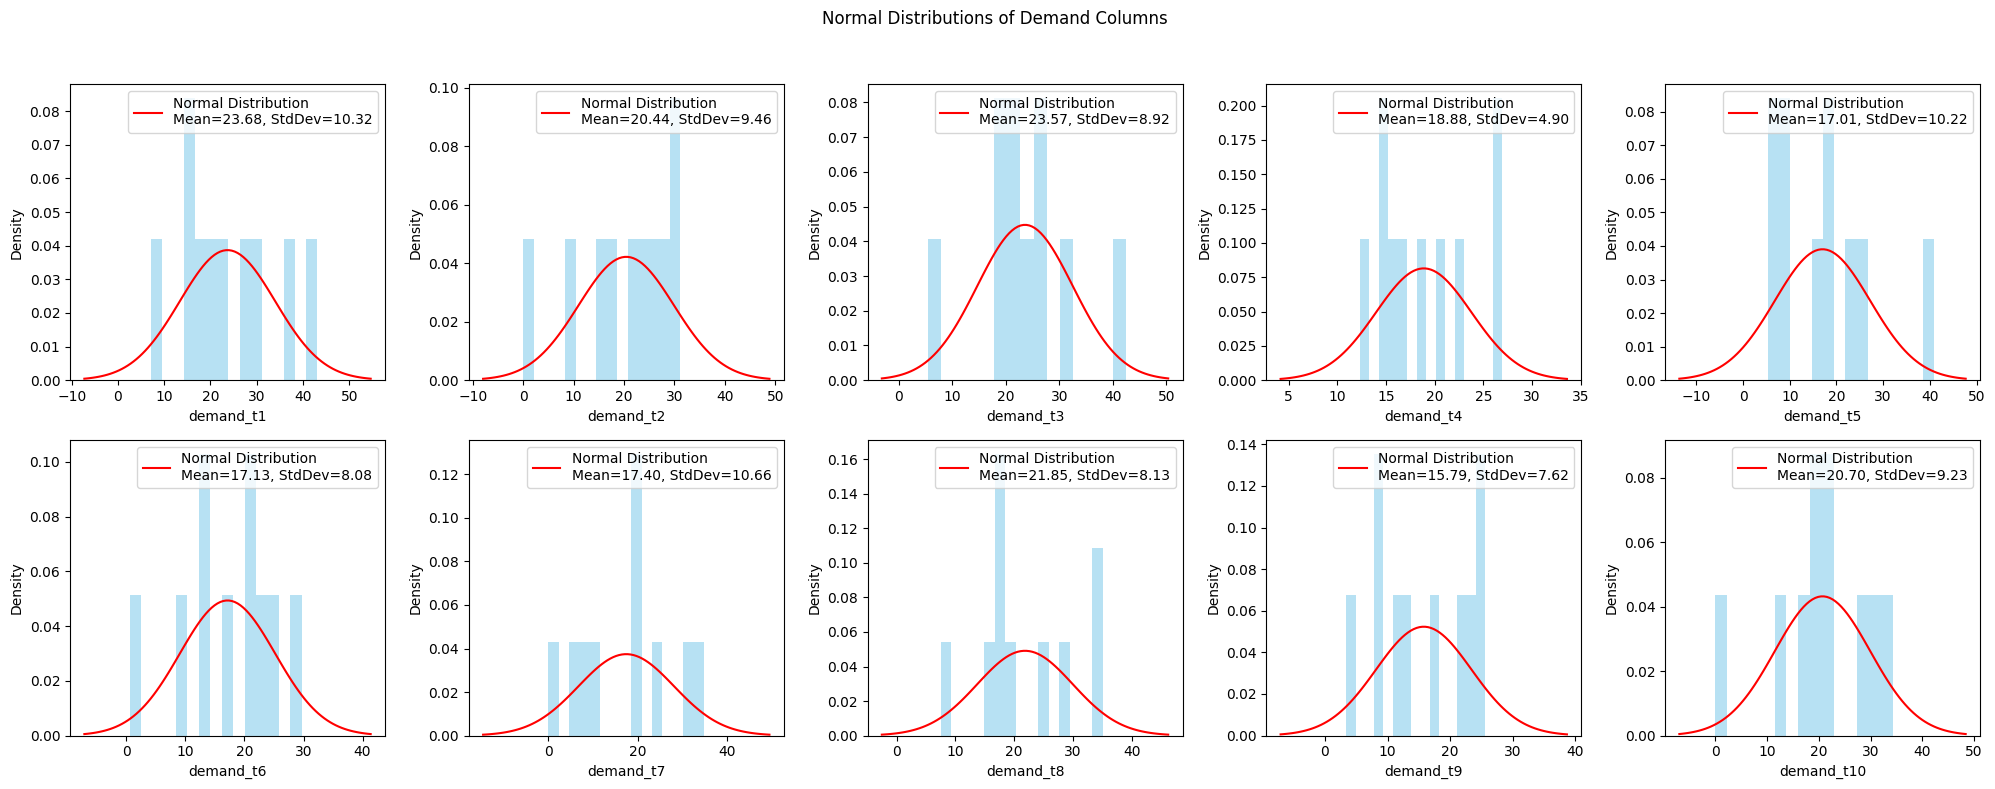

In [237]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [238]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4   demand_t5  \
demand_t1   118.236408  24.127948  48.030550  33.955253  -12.392383   
demand_t2    24.127948  99.473140  63.790151  23.695704  -85.710206   
demand_t3    48.030550  63.790151  88.329154  21.235893  -79.638330   
demand_t4    33.955253  23.695704  21.235893  26.663348  -10.883756   
demand_t5   -12.392383 -85.710206 -79.638330 -10.883756  116.091924   
demand_t6    16.116241   8.613189 -32.938966  16.745026   32.228912   
demand_t7    22.157097 -24.970866 -62.090404  18.069920   76.684196   
demand_t8    16.268080  45.895898  -5.721217  10.042401  -13.264776   
demand_t9   -31.878215  45.367014   1.475321  14.191264  -28.065669   
demand_t10   50.183955  47.086045  14.929059  43.169504   -4.896169   

            demand_t6   demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   16.116241   22.157097  16.268080 -31.878215   50.183955  
demand_t2    8.613189  -24.970866  45.895898  45.367014   47.086045  
demand_t3  -32.938966  -62.090404  -5.721217   1.475321   14.929059  
demand_t4   16.745026   18.069920  10.042401  14.191264   43.169504  
demand_t5   32.228912   76.684196 -13.264776 -28.065669   -4.896169  
demand_t6   72.600691   88.061373  55.010302  19.476697   55.578543  
demand_t7   88.061373  126.311124  48.427547   9.850332   62.100841  
demand_t8   55.010302   48.427547  73.357646  31.718429   46.910220  
demand_t9   19.476697    9.850332  31.718429  64.570880   40.202915  
demand_t10  55.578543   62.100841  46.910220  40.202915   94.586302

In [239]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   42.716828   0.566963   7.409737   3.671246  15.426347  26.316120   
demand_t2    0.566963  40.803486  22.204309   7.963896  51.955082  15.226696   
demand_t3    7.409737  22.204309  17.574762   8.244656  49.882164  18.476561   
demand_t4    3.671246   7.963896   8.244656   9.464640  10.404679  20.169270   
demand_t5   15.426347  51.955082  49.882164  10.404679  47.930167   9.933735   
demand_t6   26.316120  15.226696  18.476561  20.169270   9.933735  19.649983   
demand_t7   29.649540   0.544776  21.713956   9.474336  55.106898  46.422378   
demand_t8   36.656375  41.197781   6.476284  41.810977  33.897947  22.841529   
demand_t9    1.923895  38.667726  29.196630   9.974953  17.967645  39.256836   
demand_t10  51.461805  49.735662  22.543513  32.873797   1.407009  48.027619   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   29.649540  36.656375   1.923895   51.461805  
demand_t2    0.544776  41.197781  38.667726   49.735662  
demand_t3   21.713956   6.476284  29.196630   22.543513  
demand_t4    9.474336  41.810977   9.974953   32.873797  
demand_t5   55.106898  33.897947  17.967645    1.407009  
demand_t6   46.422378  22.841529  39.256836   48.027619  
demand_t7   50.565101  45.547044  10.526909   32.370803  
demand_t8   45.547044   1.043774  45.495697   39.118895  
demand_t9   10.526909  45.495697   1.247480   20.327276  
demand_t10  32.370803  39.118895  20.327276   44.955004

### Validate the corr matrix of damand_df is close to original setting


In [240]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.222480   0.469991   0.604747  -0.105774   0.173947   
demand_t2    0.222480   1.000000   0.680532   0.460108  -0.797588   0.101354   
demand_t3    0.469991   0.680532   1.000000   0.437584  -0.786446  -0.411327   
demand_t4    0.604747   0.460108   0.437584   1.000000  -0.195623   0.380591   
demand_t5   -0.105774  -0.797588  -0.786446  -0.195623   1.000000   0.351054   
demand_t6    0.173947   0.101354  -0.411327   0.380591   0.351054   1.000000   
demand_t7    0.181308  -0.222772  -0.587830   0.311371   0.633263   0.919590   
demand_t8    0.174678   0.537277  -0.071074   0.227069  -0.143740   0.753791   
demand_t9   -0.364838   0.566068   0.019535   0.342015  -0.324157   0.284464   
demand_t10   0.474543   0.485428   0.163330   0.859618  -0.046724   0.670691   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    0.181308   0.174678  -0.364838    0.474543  
demand_t2   -0.222772   0.537277   0.566068    0.485428  
demand_t3   -0.587830  -0.071074   0.019535    0.163330  
demand_t4    0.311371   0.227069   0.342015    0.859618  
demand_t5    0.633263  -0.143740  -0.324157   -0.046724  
demand_t6    0.919590   0.753791   0.284464    0.670691  
demand_t7    1.000000   0.503094   0.109072    0.568149  
demand_t8    0.503094   1.000000   0.460862    0.563159  
demand_t9    0.109072   0.460862   1.000000    0.514429  
demand_t10   0.568149   0.563159   0.514429    1.000000

In [241]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [242]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [243]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (5, 10), Test size: (5, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   7.169518  24.347518  25.682492  15.698204   8.999070  12.602971   
1  20.735939  21.386747  21.005380  26.911929  24.406684  29.737634   
2  15.418481  30.778253  19.774837  14.552300  16.268671  21.110606   
3  23.396067   0.000000   5.459889  16.529694  40.961346  20.683549   
4  18.284699  25.235816  22.408322  20.209340   6.231961  12.631815   

   demand_t7  demand_t8  demand_t9  demand_t10  
0   5.759692  19.851622  21.377027   17.830032  
1  34.769078  24.832722  25.341990   34.299352  
2  19.456883  35.058769  25.582935   21.528160  
3  31.365453  17.049169  10.827376   22.024015  
4  11.369732  17.980277  23.623324   19.987595  

Fold 2:
Train size: (5, 10), Test size: (5, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  15.418481  30.778253  19.774837  14.552300  16.268671  21.110606   
1  30.0436

In [244]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [245]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [246]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 201.70698664246055
std of sum: 40.82740642155722
95.0 percentile of sum: 268.8620941739808
Q_star: 268.8620941739808

mean of sum: 224.54055010756443
std of sum: 33.03104848094037
95.0 percentile of sum: 278.8717900034491
Q_star: 278.8717900034491



## Data3: Qk hat df


### Functions


In [247]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [248]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [249]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [250]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [251]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [252]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [253]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [254]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

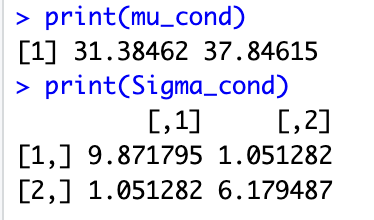
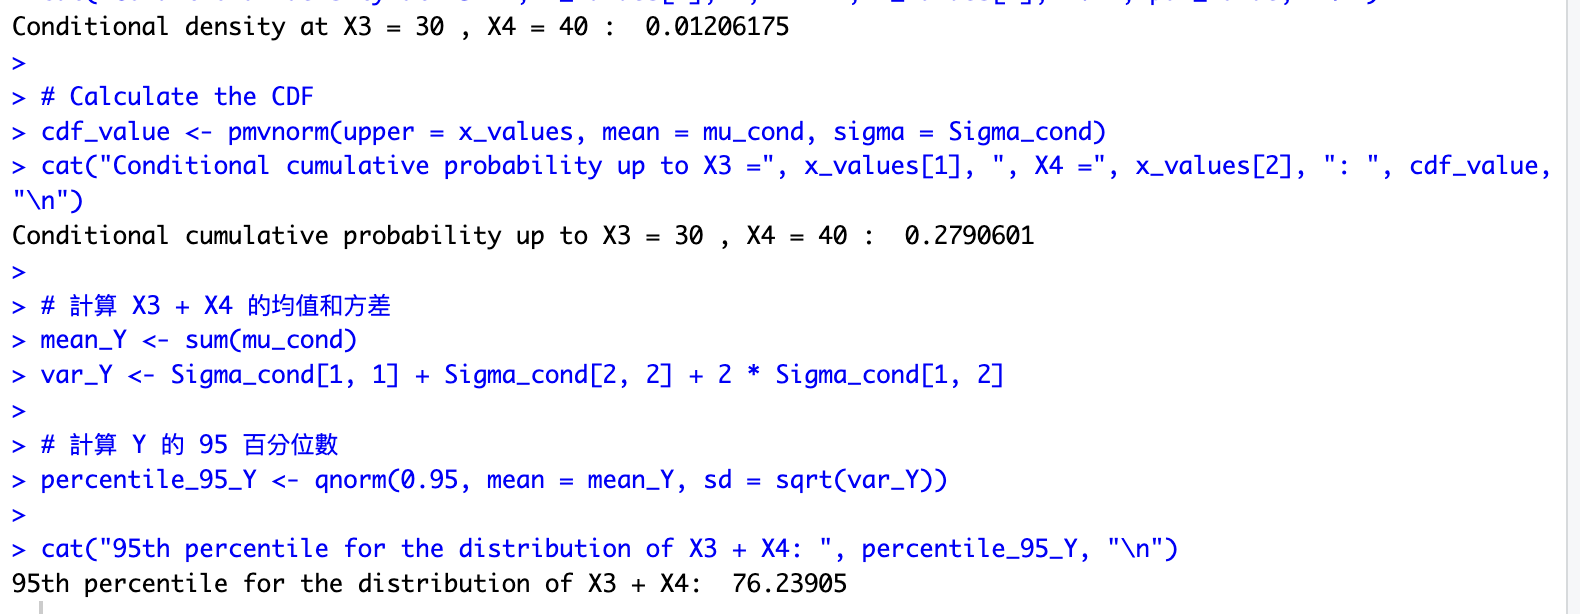


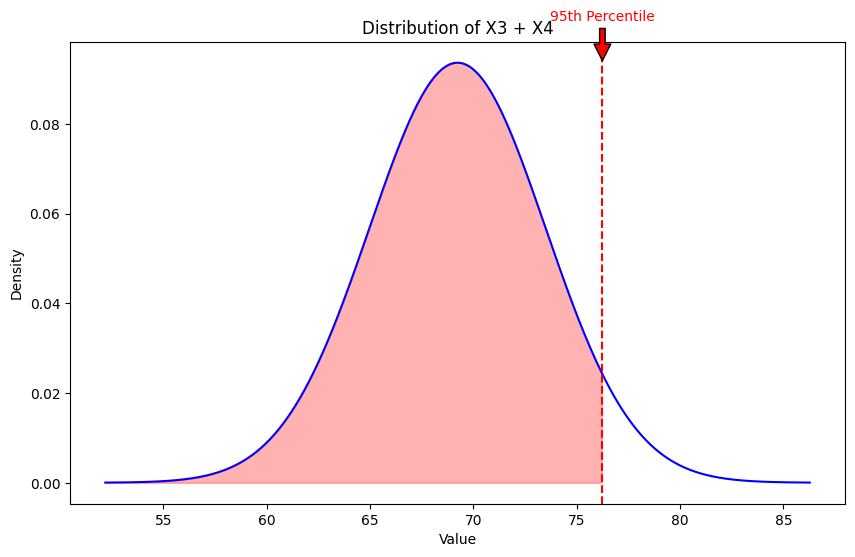

In [255]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


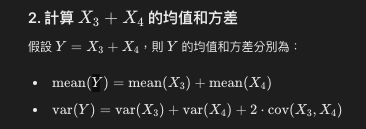


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [256]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.017454947339558
模擬計算的Y的方差: 2.9686649366161726


### Calculate Qk hat for 2~T-1 of demand_df_train


In [257]:
demand_df_train = demand_folds[0][0]

In [258]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [259]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [260]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  263.821923  215.025077  223.237680  212.766137  210.598697  193.110439   
1  279.834499  265.536186  271.628495  247.912711  244.134332  238.993186   
2  311.001610  316.553187  265.618547  257.927056  262.421312  240.627219   
3  244.605712  260.672779  273.039543  233.904304  240.433694  225.700469   
4  243.241776  215.213997  146.457135  122.217209  117.853306  105.833477   
5  251.509788  255.312450  245.924672  239.178128  219.082293  194.799823   
6  224.735814  231.300518  191.253310  178.389033  173.844726  170.687590   
7  257.414274  252.511458  242.752380  271.400991  273.327772  275.454540   
8  297.352674  298.866868  282.944922  261.486447  245.628868  248.077939   
9  271.509774  254.043255  226.090381  187.390553  184.160881  187.755239   

    Qk_hat_k8   Qk_hat_k9  
0  192.682930  189.422329  
1  232.862624  223.083751  
2  239.495943  231.840774  
3  226.469962  225.811660  
4  105.010507  105.297471  
5  195.424938  184.795952  
6  166.851191  159.280698  
7  276.332988  271.135291  
8  247.670178  251.574110  
9  190.509542  175.156375

### Plot the distribuction


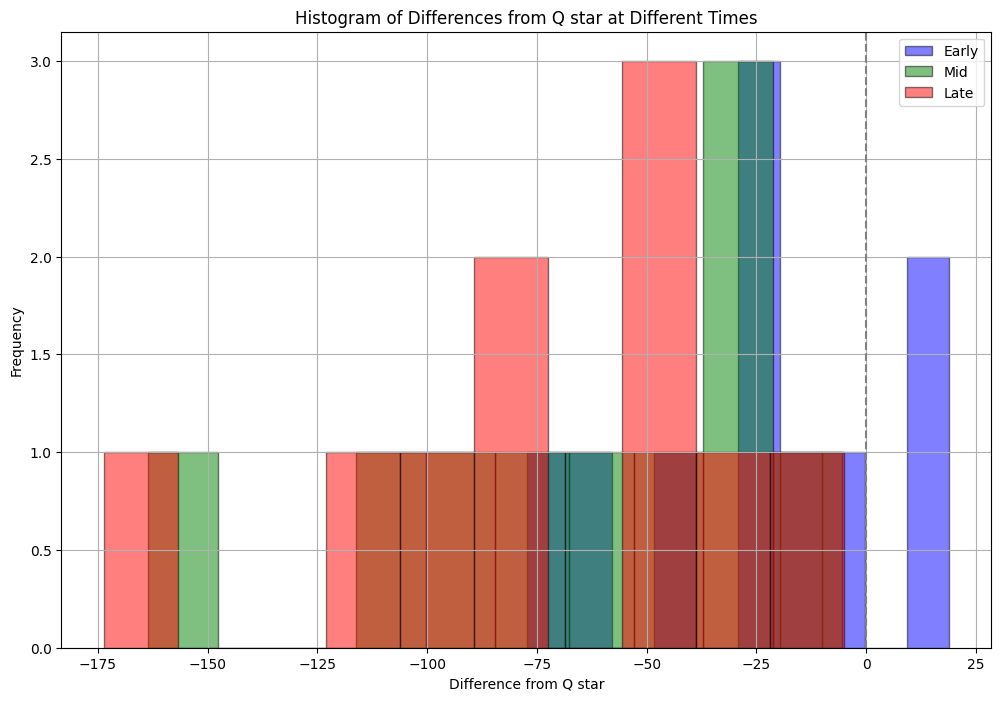

Q_star is: 278.8717900034491
Early bias: -26.238100547146963
Mid bias: -63.36851101622585
Late bias: -74.33632930391066


In [261]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

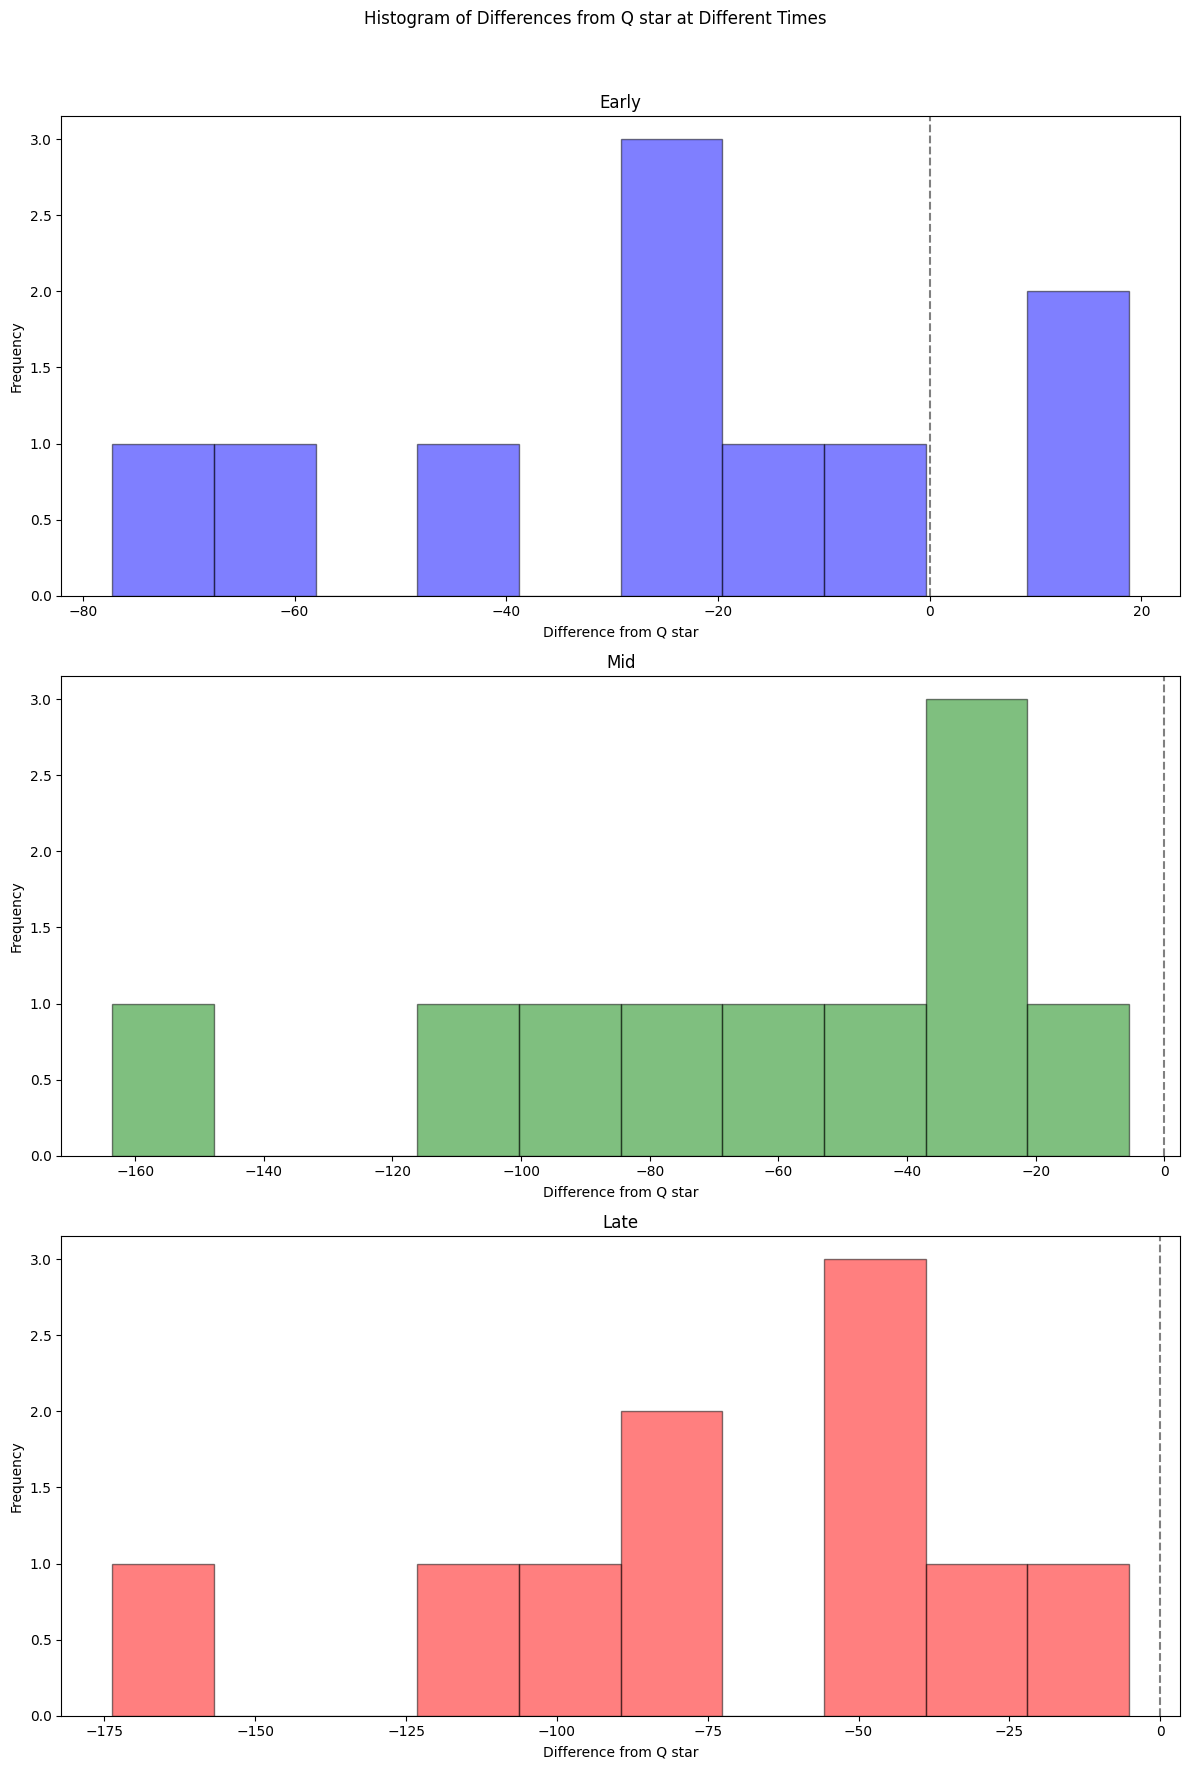

In [262]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [263]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value, holding_cost):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_holding_costs = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量
        holding_costs = 0  # 追蹤總持有成本

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales
            holding_costs += holding_cost * inventory

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print(f"Holding Cost: {holding_costs}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = (
            operation_profit
            - left_penalty_cost
            - ((price - cost) * total_lost)
            - holding_costs
        )

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [264]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [265]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [266]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [267]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [268]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 引入二進制變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")

            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i] - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(
                Sold_0s[i] >= Q0_vars[i] - M * Sold_0_binary, name=f"Sold_0_lb2_{i}"
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Qk_hat.append(Q_hats[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [269]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [270]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [271]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
    holding_cost,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            holding_cost=holding_cost,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                all_losses,
                all_lefts,
                all_profits,
                all_operation_profits,
                all_Fs,
                all_Q0s,
                all_Q1s,
                beta_values,
                tau_values,
                all_holding_costs_0,
                all_holding_costs_1,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
                all_Qk_hat,
                all_sold0s,
                all_sold1s,
                all_demand_up,
                all_demand_down,
                all_Q1_plus_lefts,
            ) = result

            # 计算平均值
            average_losses = sum(all_losses) / len(all_losses) if all_losses else 0
            average_lefts = sum(all_lefts) / len(all_lefts) if all_lefts else 0
            average_profits = sum(all_profits) / len(all_profits) if all_profits else 0
            average_operation_profits = (
                sum(all_operation_profits) / len(all_operation_profits)
                if all_operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(all_Fs)
            results_dict["Q0_vars"].append(all_Q0s)
            results_dict["Q1_vars"].append(all_Q1s)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "R": [x - 2 for x in all_Rs],
                    "F": all_Fs,
                    "profits": all_profits,
                    "losses": all_losses,
                    "lefts": all_lefts,
                    "operation_profits": all_operation_profits,
                    "Q0": all_Q0s,
                    "Q1": all_Q1s,
                    "hc0": all_holding_costs_0,
                    "hc1": all_holding_costs_1,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                    "Qk_hat": all_Qk_hat,
                    "Sold0s": all_sold0s,
                    "Sold1s": all_sold1s,
                    "demand_up": all_demand_up,
                    "demand_down": all_demand_down,
                    "Q1_plus_lefts": all_Q1_plus_lefts,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [272]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [273]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [274]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [275]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [276]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [277]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

### S4 - Beta with softmax


In [278]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助二進位變數
            Sold_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_0_binary_{i}")
            Sold_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Sold_1_binary_{i}")
            Left_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_0_binary_{i}")
            Left_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Left_1_binary_{i}")
            Lost_0_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_0_binary_{i}")
            Lost_1_binary = model.addVar(vtype=GRB.BINARY, name=f"Lost_1_binary_{i}")

            # Sold_0 的線性化
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Sold_0_ub1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Sold_0_ub2_{i}")
            model.addConstr(
                Sold_0s[i]
                >= total_demand_up_to_k_minus_1_vars[i]
                + Q0_vars[i]
                - M * (1 - Sold_0_binary),
                name=f"Sold_0_lb1_{i}",
            )
            model.addConstr(Sold_0s[i] >= 0, name=f"Sold_0_nonneg_{i}")

            # Left_0 的線性化
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Left_0_lb1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Left_0_lb2_{i}")
            model.addConstr(
                Left_0s[i] <= Q0_vars[i] - Sold_0s[i] + M * (1 - Left_0_binary),
                name=f"Left_0_ub1_{i}",
            )
            model.addConstr(Left_0s[i] <= M * Left_0_binary, name=f"Left_0_ub2_{i}")

            # Lost_0 的線性化
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Lost_0_lb1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Lost_0_lb2_{i}")
            model.addConstr(
                Lost_0s[i]
                <= total_demand_up_to_k_minus_1_vars[i]
                - Q0_vars[i]
                + M * (1 - Lost_0_binary),
                name=f"Lost_0_ub1_{i}",
            )
            model.addConstr(Lost_0s[i] <= M * Lost_0_binary, name=f"Lost_0_ub2_{i}")

            # Q1 + Left_0 平衡式
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Q1_plus_left_balance_{i}",
            )

            # Sold_1 的線性化
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i], name=f"Sold_1_ub1_{i}"
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Sold_1_ub2_{i}")
            model.addConstr(
                Sold_1s[i]
                >= total_demand_from_k_to_T_vars[i]
                + Q1_plus_lefts[i]
                - M * (1 - Sold_1_binary),
                name=f"Sold_1_lb1_{i}",
            )
            model.addConstr(Sold_1s[i] >= 0, name=f"Sold_1_nonneg_{i}")

            # Left_1 的線性化
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Left_1_lb1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Left_1_lb2_{i}")
            model.addConstr(
                Left_1s[i] <= Q1_plus_lefts[i] - Sold_1s[i] + M * (1 - Left_1_binary),
                name=f"Left_1_ub1_{i}",
            )
            model.addConstr(Left_1s[i] <= M * Left_1_binary, name=f"Left_1_ub2_{i}")

            # Lost_1 的線性化
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Lost_1_lb1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Lost_1_lb2_{i}")
            model.addConstr(
                Lost_1s[i]
                <= total_demand_from_k_to_T_vars[i]
                - Q1_plus_lefts[i]
                + M * (1 - Lost_1_binary),
                name=f"Lost_1_ub1_{i}",
            )
            model.addConstr(Lost_1s[i] <= M * Lost_1_binary, name=f"Lost_1_ub2_{i}")

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(features_num + 1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []
                all_Qk_hat = []
                all_sold0s = []
                all_sold1s = []
                all_demand_up = []
                all_demand_down = []
                all_Q1_plus_lefts = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    q1_plus_left = Q1_plus_lefts[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X
                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)
                    all_sold0s.append(sold0)
                    all_sold1s.append(sold1)
                    all_demand_up.append(total_demand_up)
                    all_demand_down.append(total_demand_down)
                    all_Q1_plus_lefts.append(q1_plus_left)
                    all_Qk_hat.append(Q_hats[i].X)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    all_Qk_hat,
                    all_sold0s,
                    all_sold1s,
                    all_demand_up,
                    all_demand_down,
                    all_Q1_plus_lefts,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [279]:
def fully_flexible_beta_with_softmax_4(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    holding_cost,
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        holding_cost=holding_cost,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_holding_costs_0,
            all_holding_costs_1,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            all_Qk_hat,
            all_sold0s,
            all_sold1s,
            all_demand_up,
            all_demand_down,
            all_Q1_plus_lefts,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=all_holding_costs_0,
            holding_costs_1s=all_holding_costs_1,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
            all_Qk_hat=all_Qk_hat,
            all_sold0s=all_sold0s,
            all_sold1s=all_sold1s,
            all_demand_up=all_demand_up,
            all_demand_down=all_demand_down,
            all_Q1_plus_lefts=all_Q1_plus_lefts,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [280]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [281]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [282]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [283]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [284]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [285]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [286]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [287]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
    holding_cost,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [288]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411262226

In [289]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.5


In [290]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [291]:
training_df.shape

(5, 2)

In [292]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 201.70698664246055
std of sum: 40.82740642155722
50.0 percentile of sum: 201.70698664246055
Q_star: 201.70698664246055


In [293]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  169.948367  154.283695  155.531778  159.318145  159.318145  159.318145   
1  213.772218  225.357691  228.701163  263.427456  263.427456  263.427456   
2  196.595139  215.644855  210.765286  219.529895  219.529895  219.529895   
3  222.365275  193.427068  191.801496  188.296556  188.296556  188.296556   
4  205.853934  219.821625  221.735210  177.962882  177.962882  177.962882   

    Qk_hat_k8   Qk_hat_k9  
0  159.318145  159.318145  
1  263.427456  263.427456  
2  219.529895  219.529895  
3  188.296556  188.296556  
4  177.962882  177.962882

## Training


### S0 - One-time procurement strategy


In [294]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/5 with initial inventory Q_star=201.70698664246055
--------------------------------------------------
Day 1
Demand      : 7.169517745877684
Sales       : 7.169517745877684
Loss        : 0
Left        : 194.53746889658288
Inventory   : 194.53746889658288
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 24.34751786611708
Sales       : 24.34751786611708
Loss        : 0
Left        : 170.1899510304658
Inventory   : 170.1899510304658
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 25.682491527094953
Sales       : 25.682491527094953
Loss        : 0
Left        : 144.50745950337085
Inventory   : 144.50745950337085
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 15.698204374437081
Sales       : 15.698204374

In [295]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0   0.000000  42.388842       79659.072310  58464.651300
1  61.720469   0.000000      100853.493321  69993.258695
2  17.822908   0.000000      100853.493321  91942.039307
3   0.000000  13.410430       94148.278073  87443.062824
4   0.000000  23.744105       88981.440940  77109.388558

### S1 - Grid for Fixed F & Fixed Rk


In [296]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 201.70698664246055
期初庫存 Q0: 20.170698664246057
重新估計量 Qk_hat: 169.9483670978243
訂貨量 Q1 為 149.77766843357824

第一階段：期初庫存 Q0: 20.170698664246057，需求量為 7.169517745877684，Sold_0 為 7.169517745877684，Left_0 為 13.001180918368373，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 162.7788493519466，需求量為 152.1486268750113，Sold_1 為 152.1486268750113，Left_1 為 10.630222476935302，Lost_1 為 0

統計結果：Sold 為 159.31814462088897, Lost 為 0 Left_Penalty_Cost 為 5315.111238467651，Lost_Penalty_Cost 為 0，Profit 為 74343.96107197684
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 201.70698664246055
期初庫存 Q0: 20.170698664246057
重新估計量 Qk_hat: 213.77221791946053
訂貨量 Q1 為 193.60151925521447

第一階段：期初庫存 Q0: 20.170698664246057，需求量為 20.735939115864362，Sold_0 為 20.170698664246057，Left_0 為 0.0，Lost_0 為 0.5652404516183047
第二階段：期初庫存 Q1+left_0 為 193.60151925521447，需求量為 242.69151677936696，Sold_1 為 193.60151925521447，Left_1 為 0.0，Lost_1 為 49.089997524152494

統計結果：Sold 為 213.77221791946

R(T)    F                                                 Q0  \
42     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
41     6  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
33     5  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
32     5  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
31     5  0.5  [100.85349332123027, 100.85349332123027, 100.8...   
..   ...  ...                                                ...   
55     8  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
65     9  0.3  [60.512095992738175, 60.512095992738175, 60.51...   
54     8  0.1  [20.170698664246057, 20.170698664246057, 20.17...   
64     9  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
63     9  0.1  [20.170698664246057, 20.170698664246057, 20.17...   

                                                   Q1  average_profits  \
42  [18.123253971166548, 122.23256524550888, 78.33...    100853.493321   
41  [38.293952635412595, 142.4032639097549, 98.505...    100853.493321   
33  [18.123253971166463, 122.23256524550877, 78.33...    100853.493321   
32  [38.29395263541251, 142.4032639097548, 98.5057...    100853.493321   
31  [58.464651299658584, 162.5739625740009, 118.67...    100853.493321   
..                                                ...              ...   
55  [118.97674729239685, 223.0860585667392, 179.18...    -40036.581445   
65  [98.80604862815082, 202.91535990249315, 159.01...    -44212.300990   
54  [139.1474459566429, 243.25675723098527, 199.35...    -70292.629442   
64  [118.97674729239688, 223.0860585667392, 179.18...    -74468.348986   
63  [139.14744595664294, 243.25675723098527, 199.3...   -104724.396983   

    average_losses  average_lefts  average_operation_profits  
42    2.557954e-14   5.684342e-15              100853.493321  
41    3.126388e-14   5.684342e-15              100853.493321  
33    1.250555e-13   9.947598e-14              100853.493321  
32    1.250555e-13   9.947598e-14              100853.493321  
31    1.250555e-13   9.947598e-14              100853.493321  
..             ...            ...                        ...  
55    9.392672e+01   9.392672e+01               53890.135066  
65    9.671053e+01   9.671053e+01               52498.228551  
54    1.140974e+02   1.140974e+02               43804.785734  
64    1.168812e+02   1.168812e+02               42412.879219  
63    1.370519e+02   1.370519e+02               32327.529887  

[72 rows x 8 columns]

In [297]:
stimulation_results_df_1

R(T)    F        profits        losses         lefts     Left0s  \
0     6  0.6   79659.072310  4.263256e-14  0.000000e+00  39.127391   
1     6  0.6  131713.727948  5.684342e-14  0.000000e+00   6.577513   
2     6  0.6  109764.947336  0.000000e+00  2.842171e-14  24.231650   
3     6  0.6   94148.278073  2.842171e-14  0.000000e+00  34.677197   
4     6  0.6   88981.440940  2.842171e-14  0.000000e+00  28.654053   

         Left1s  operation_profits          Q0          Q1  
0  0.000000e+00       79659.072310  121.024192   38.293953  
1  0.000000e+00      131713.727948  121.024192  142.403264  
2  2.842171e-14      109764.947336  121.024192   98.505703  
3  0.000000e+00       94148.278073  121.024192   67.272364  
4  0.000000e+00       88981.440940  121.024192   56.938690

In [298]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 201.70698664246055
Maximum Profit: 100853.49332123026


In [299]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
42     6  0.7    100853.493321
41     6  0.6    100853.493321
33     5  0.7    100853.493321

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


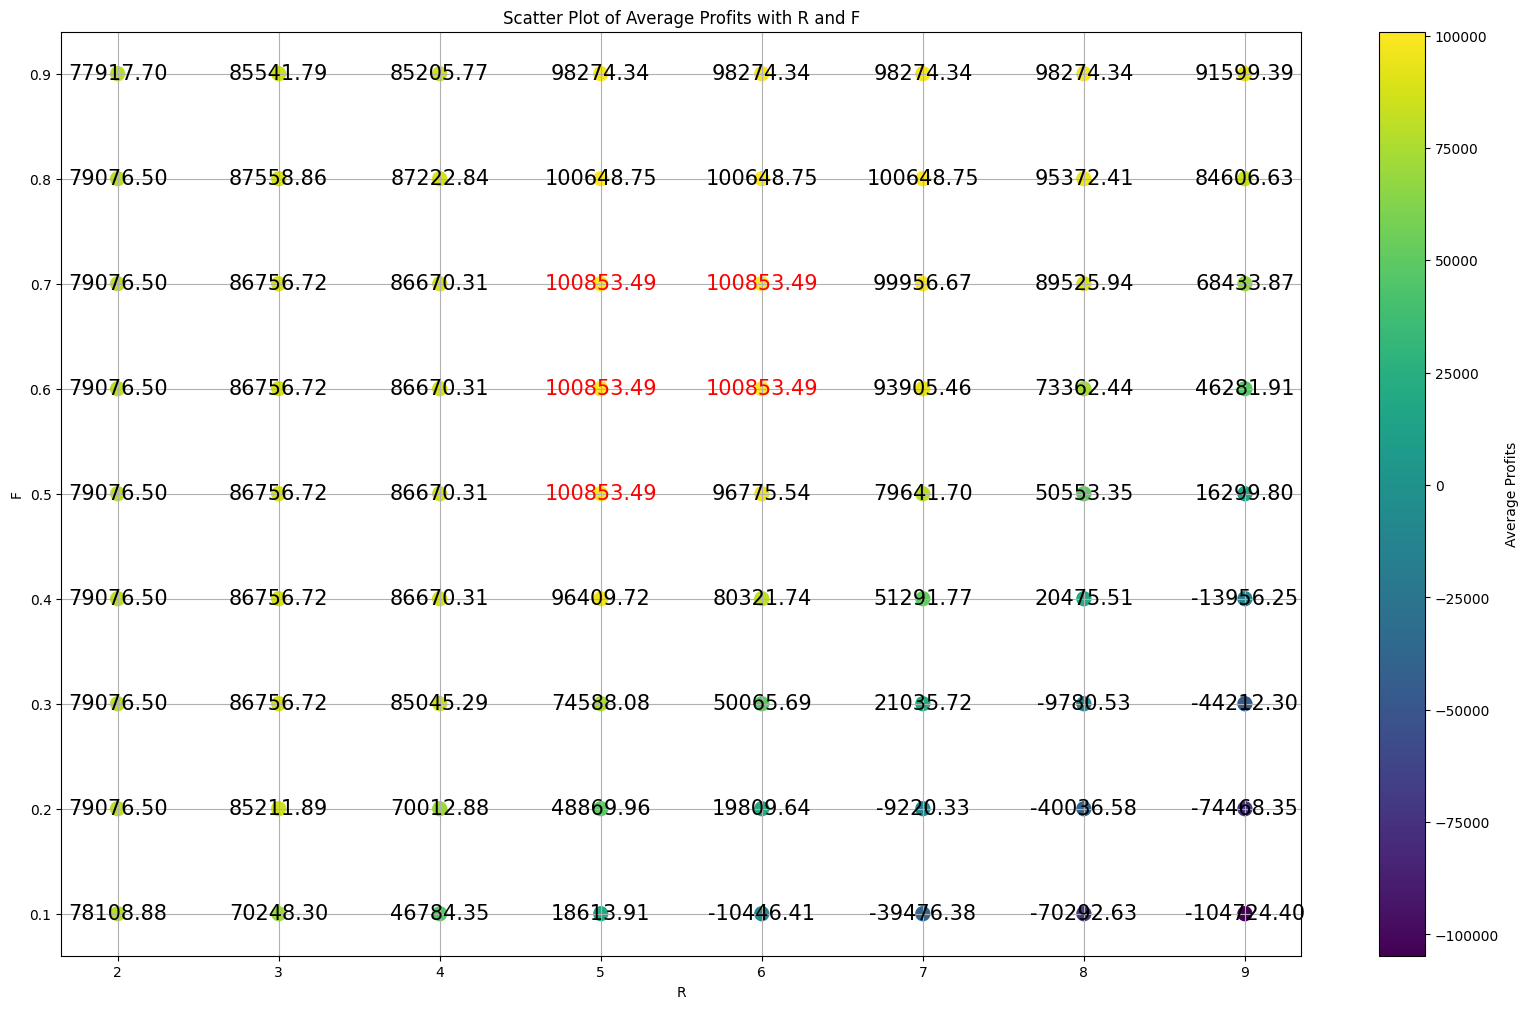

In [300]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


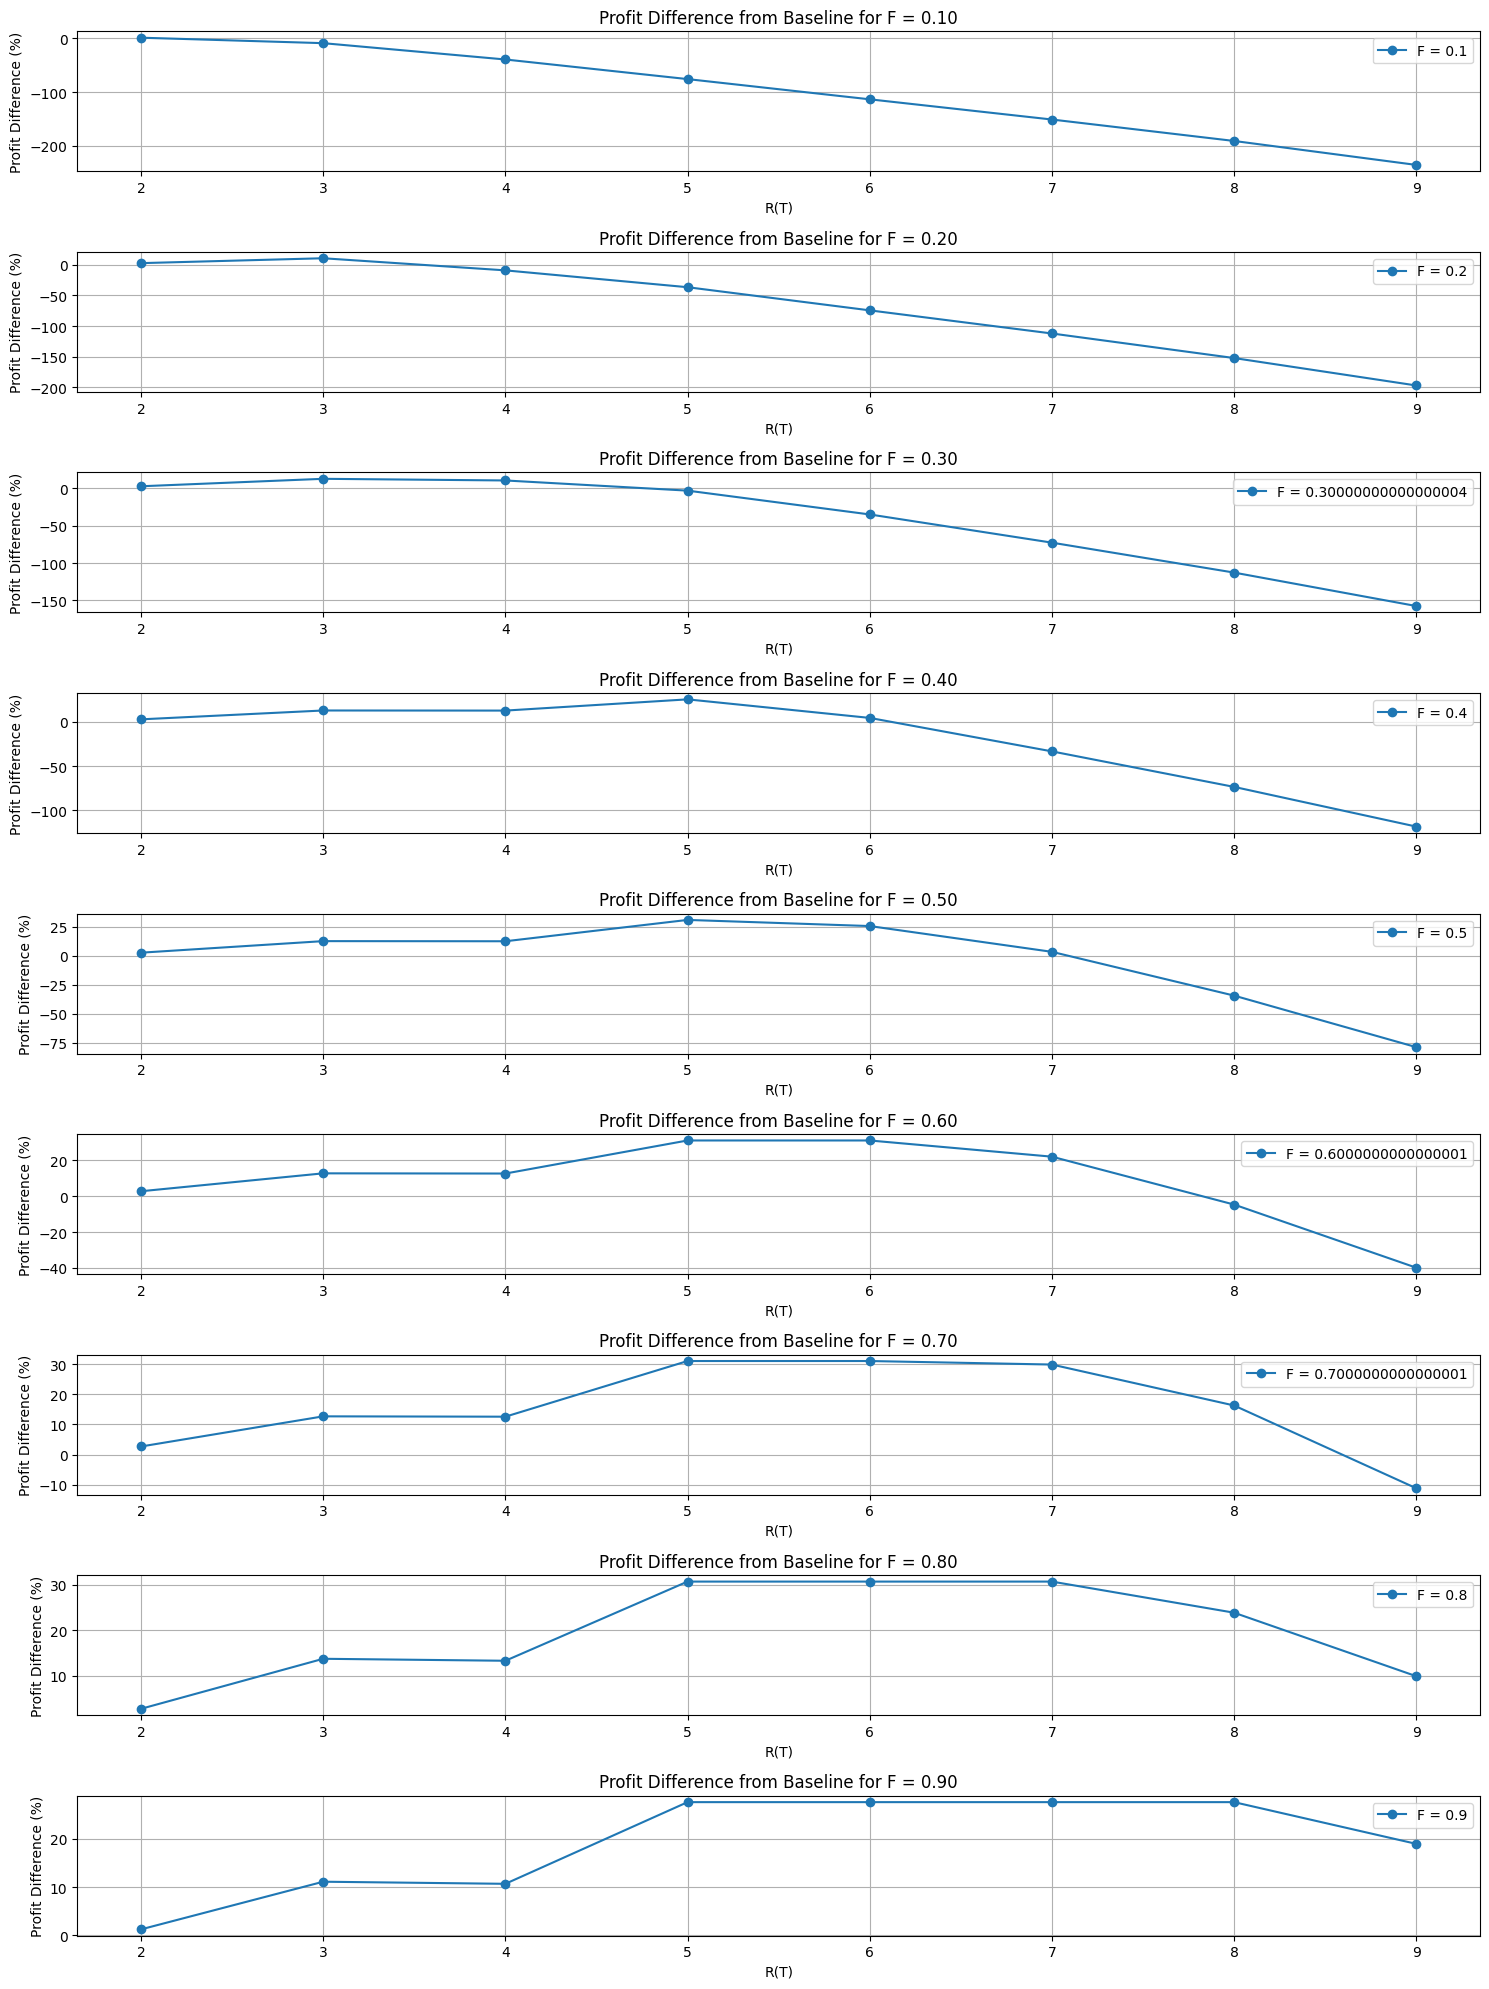

In [301]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [302]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 78108.88484304702




max_profit is changed from 78108.88484304702 to 79076.49523181857
























max_profit is changed from 79076.49523181857 to 79076.49523181858












max_profit is changed from 79076.49523181858 to 85211.8924966234




max_profit is changed from 85211.8924966234 to 86756.71692216808




















max_profit is changed from 86756.71692216808 to 87558.86241124778
























































max_profit is changed from 87558.86241124778 to 96409.71820551831




max_profit is changed from 96409.71820551831 to 100853.49332123011








































max_profit is changed from 100853.49332123011 to 100853.49332123026


























































































































R(T)    F                                                 Q0  \
42     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
41     6  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
33     5  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
32     5  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
31     5  0.5  [100.85349332123027, 100.85349332123027, 100.8...   
..   ...  ...                                                ...   
55     8  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
65     9  0.3  [60.512095992738175, 60.512095992738175, 60.51...   
54     8  0.1  [20.170698664246057, 20.170698664246057, 20.17...   
64     9  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
63     9  0.1  [20.170698664246057, 20.170698664246057, 20.17...   

                                                   Q1  average_profits  \
42  [18.123253971166548, 122.23256524550888, 78.33...    100853.493321   
41  [38.293952635412595, 142.4032639097549, 98.505...    100853.493321   
33  [18.123253971166463, 122.23256524550877, 78.33...    100853.493321   
32  [38.29395263541251, 142.4032639097548, 98.5057...    100853.493321   
31  [58.464651299658584, 162.5739625740009, 118.67...    100853.493321   
..                                                ...              ...   
55  [118.97674729239685, 223.0860585667392, 179.18...    -40036.581445   
65  [98.80604862815082, 202.91535990249315, 159.01...    -44212.300990   
54  [139.1474459566429, 243.25675723098527, 199.35...    -70292.629442   
64  [118.97674729239688, 223.0860585667392, 179.18...    -74468.348986   
63  [139.14744595664294, 243.25675723098527, 199.3...   -104724.396983   

    average_losses  average_lefts  average_operation_profits  
42    2.557954e-14   5.684342e-15              100853.493321  
41    3.126388e-14   5.684342e-15              100853.493321  
33    1.250555e-13   9.947598e-14              100853.493321  
32    1.250555e-13   9.947598e-14              100853.493321  
31    1.250555e-13   9.947598e-14              100853.493321  
..             ...            ...                        ...  
55    9.392672e+01   9.392672e+01               53890.135066  
65    9.671053e+01   9.671053e+01               52498.228551  
54    1.140974e+02   1.140974e+02               43804.785734  
64    1.168812e+02   1.168812e+02               42412.879219  
63    1.370519e+02   1.370519e+02               32327.529887  

[72 rows x 8 columns]

In [303]:
stimulation_results_df_8

R(T)    F        profits        losses         lefts  operation_profits  \
0     6  0.6   79659.072310  4.263256e-14  0.000000e+00       79659.072310   
1     6  0.6  131713.727948  5.684342e-14  0.000000e+00      131713.727948   
2     6  0.6  109764.947336  0.000000e+00  2.842171e-14      109764.947336   
3     6  0.6   94148.278073  2.842171e-14  0.000000e+00       94148.278073   
4     6  0.6   88981.440940  2.842171e-14  0.000000e+00       88981.440940   

           Q0          Q1         hc0         hc1     Left0s        Left1s  \
0  121.024192   38.293953  496.113838  154.842687  39.127391  0.000000e+00   
1  121.024192  142.403264  675.012421  297.961553   6.577513  0.000000e+00   
2  121.024192   98.505703  609.403861  245.474705  24.231650  2.842171e-14   
3  121.024192   67.272364  557.434383  203.899123  34.677197  0.000000e+00   
4  121.024192   56.938690  516.542338  171.185487  28.654053  0.000000e+00   

   lost0s        lost1s  
0       0  4.263256e-14  
1       0  5.684342e-14  
2       0  0.000000e+00  
3       0  2.842171e-14  
4       0  2.842171e-14

In [304]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 201.70698664246055
Maximum Profit: 100853.49332123026


In [305]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
42     6  0.7    100853.493321
41     6  0.6    100853.493321
33     5  0.7    100853.493321

Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


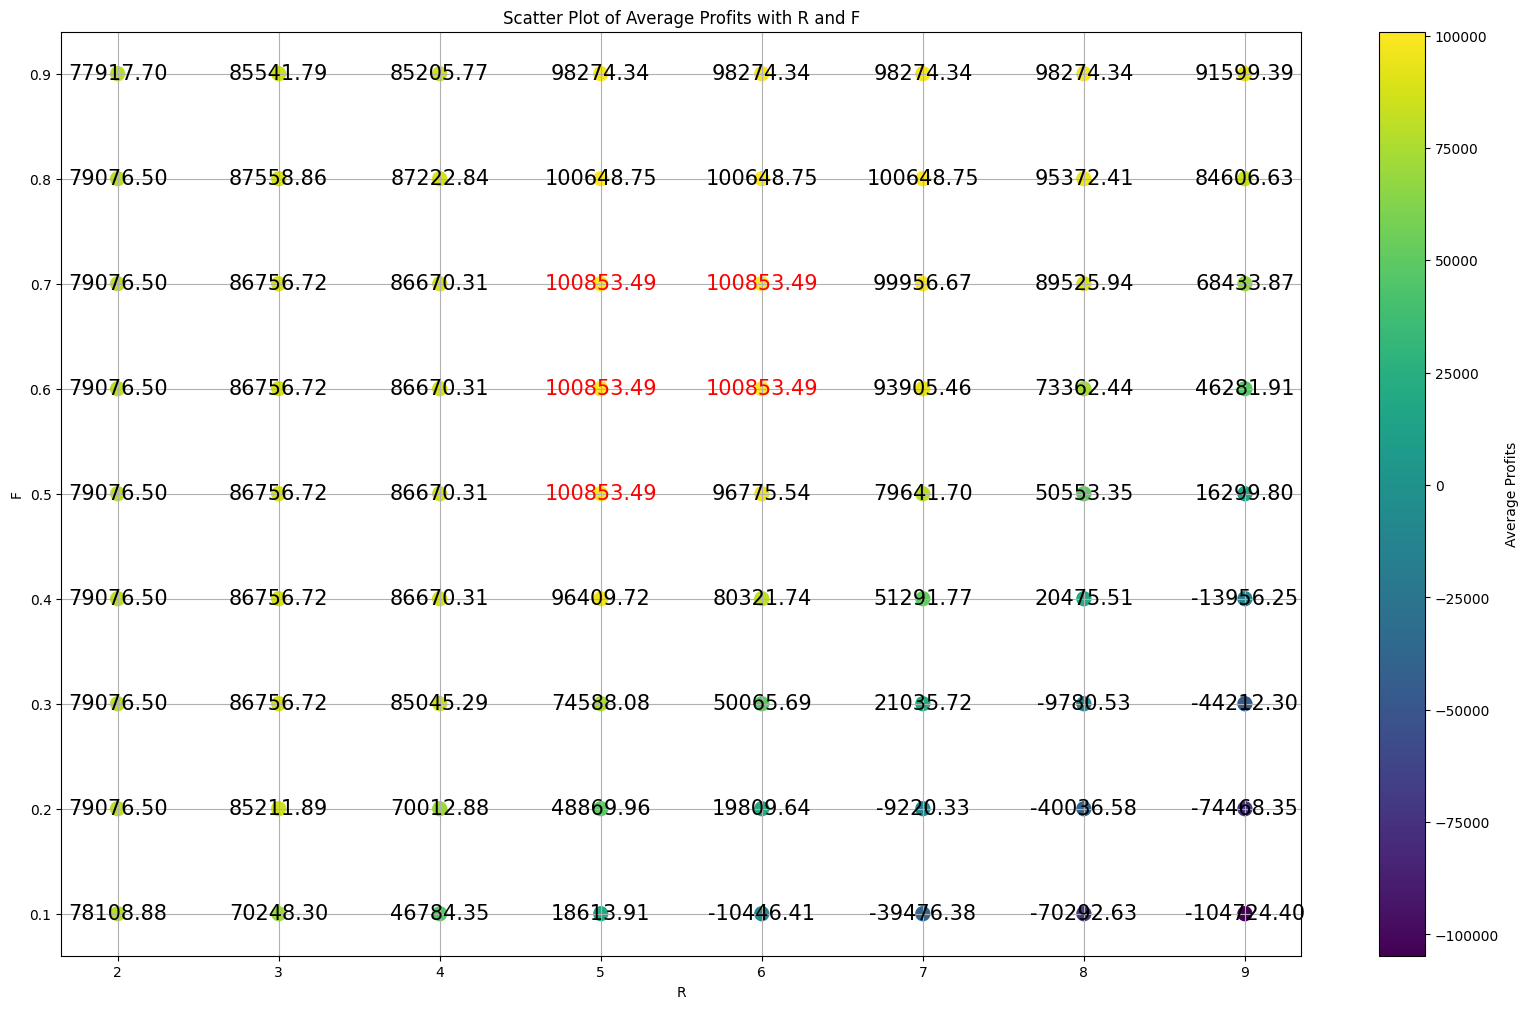

In [306]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


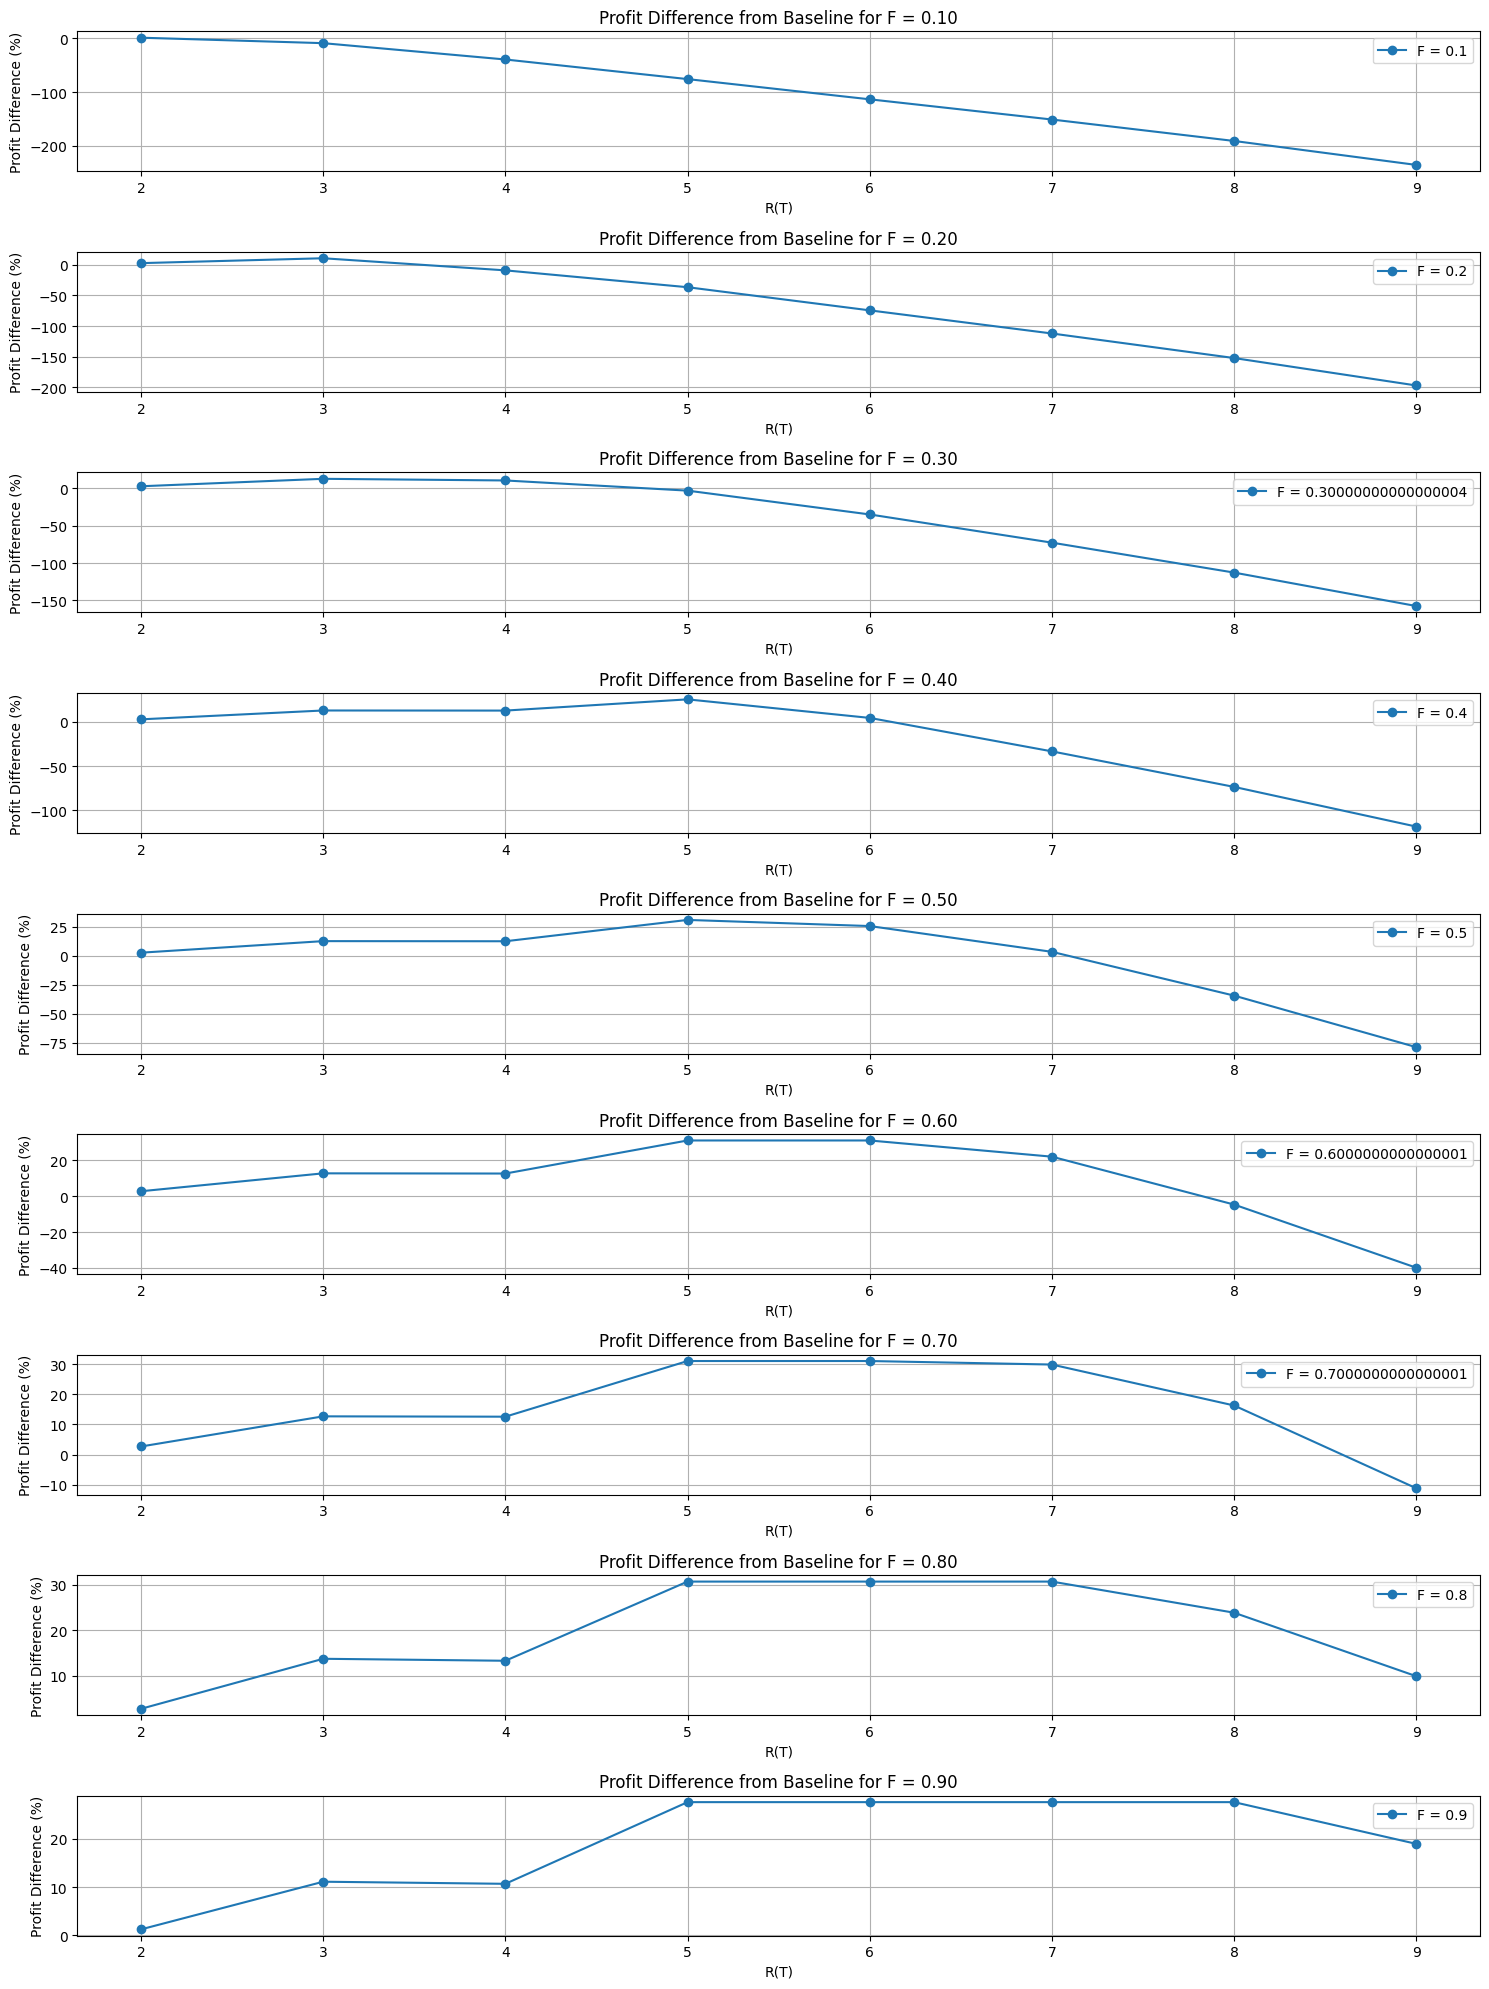

In [307]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [308]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 210 rows, 178 columns and 660 nonzeros
Model fingerprint: 0xcd21398c
Model has 10 general constraints
Variable types: 103 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
Presolve removed 143 rows and 113 columns
Presolve time: 0.01s
Presolved: 67 rows, 65 columns, 211 nonzeros
Variable types: 43 continuous, 22 integer (22 binary)
Found heurist

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/675930583.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

        4         4         4         2         2         2           0s

IIS computed: 4 constraints, 2 bounds
IIS runtime: 0.02 seconds (0.01 work units)
導致不可行的約束： Set_R_1_0_To_1
導致不可行的約束： Define_Q_hat_1
導致不可行的約束： Adjust_Q_hat_1
導致不可行的變量： Q0_var[1], IIS下界： 0, IIS上界： 1
導致不可行的變量： Q1_var[1], IIS下界： 0, IIS上界： 1
模型沒有最佳解


R(T)                R  average_profits  average_losses  average_lefts  \
1     3  [1, 1, 1, 1, 1]     87763.606881        8.390961     150.184371   
2     4  [2, 2, 2, 2, 2]     86670.312694        9.455454     128.648899   
0     2  [0, 0, 0, 0, 0]     79076.495232       14.517999     177.191634   

   average_operation_profits  \
1               96658.012834   
2               96125.766445   
0               93594.493958   

                                        alpha_values  \
1        [0.0, 3.495266477455761, 6.068219576717649]   
2        [0.6506216631922249, 0.0, 2.16897286678918]   
0  [0.11744596076574089, 0.24580096037453592, 2.2...   

                                              F_vars  \
1  [0.7898494111326531, 0.9141798059199618, 0.866...   
2  [0.7710777908182428, 0.9627212450477464, 0.857...   
0  [0.8425507213543845, 0.9277310253708273, 0.903...   

                                             Q0_vars  \
1  [159.31814462088937, 184.3964539015049, 174.68...   
2  [155.53177765287327, 194.18760131525875, 172.9...   
0  [169.9483670978243, 187.12982954226968, 182.22...   

                                             Q1_vars  
1  [0.0, 40.961237031371454, 40.96116181241634, 0...  
2  [0.0, 34.513561670475035, 37.805514894698476, ...  
0  [0.0, 26.642388377190855, 14.367306685928652, ...

In [309]:
stimulation_results_df_2

R(T)  R         F        profits     losses       lefts  operation_profits  \
0     3  1  0.789849   79659.072310   0.000000  127.801109       79659.072310   
1     3  1  0.914180   93643.962986  38.069765  142.273768      112678.845467   
2     3  1  0.866027  105879.907427   3.885040  128.486959      107822.427381   
3     3  1  0.958951   91583.022078   0.000000  175.161513       94148.278073   
4     3  1  0.886733   68052.069604   0.000000  177.198506       88981.440940   

           Q0         Q1         hc0  ...  demand_up  demand_down     Sold0s  \
0  159.318145   0.000000  287.119254  ...  31.517036   127.801109  31.517036   
1  184.396454  40.961237  367.631459  ...  42.122686   221.304770  42.122686   
2  174.683693  40.961162  344.131814  ...  46.196734   173.333160  46.196734   
3  193.427068   0.000000  363.458070  ...  23.396067   164.900490  23.396067   
4  178.860279  40.961346  355.161388  ...  43.520515   134.442367  43.520515   

       Sold1s      Left0s     Left1s  lost0s     lost1s      Qk_hat  \
0  127.801109  127.801109   0.000000     0.0   0.000000  154.283695   
1  183.235005  142.273768   0.000000     0.0  38.069765  225.357691   
2  169.448121  128.486959   0.000000     0.0   3.885040  215.644855   
3  164.900490  170.031002   5.130512     0.0   0.000000  193.427068   
4  134.442367  135.339764  41.858743     0.0   0.000000  219.821625   

   Q1_plus_lefts  
0     127.801109  
1     183.235005  
2     169.448121  
3     170.031002  
4     176.301109  

[5 rows x 21 columns]

In [310]:
stimulation_results_df_2_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_2, Q_star, Qk_hat_df_train
)
stimulation_results_df_2_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0  demand_up     Sold0s      Left0s  \
0  1  201.706987  0.789849  159.318145  31.517036  31.517036  127.801109   
1  1  201.706987  0.914180  184.396454  42.122686  42.122686  142.273768   
2  1  201.706987  0.866027  174.683693  46.196734  46.196734  128.486959   
3  1  201.706987  0.958951  193.427068  23.396067  23.396067  170.031002   
4  1  201.706987  0.886733  178.860279  43.520515  43.520515  135.339764   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  Q0-Sold0s(left0)  \
0     0.0  154.283695  -5.034450  ...   0.000000   0.000000        127.801109   
1     0.0  225.357691  40.961237  ...   0.000000  38.069765        142.273768   
2     0.0  215.644855  40.961162  ...   0.000000   3.885040        128.486959   
3     0.0  193.427068   0.000000  ...   5.130512   0.000000        170.031002   
4     0.0  219.821625  40.961346  ...  41.858743   0.000000        135.339764   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0          -127.801109                 0.000000e+00   
1          -142.273768                -1.862645e-09   
2          -128.486959                -1.862645e-09   
3          -170.031002                 5.130512e+00   
4          -135.339764                 4.185874e+01   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                          0.000000             127.801109   
1                         38.069765             142.273768   
2                          3.885040             128.486959   
3                         -5.130512             170.031002   
4                        -41.858743             135.339764   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                          0.000000   
1                       0.0                          0.000000   
2                       0.0                          0.000000   
3                       0.0                          5.130512   
4                       0.0                         41.858743   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                               0.000000  
1                              38.069765  
2                               3.885040  
3                               0.000000  
4                               0.000000  

[5 rows x 24 columns]

In [311]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                -0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

In [312]:
# # 驗證 Q1 計算是否正確

# if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
#     stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
#         :, stimulation_results_df_2.iloc[0, 0]
#     ]
#     stimulation_results_df_2["Qk_hat-Q0"] = (
#         stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
#     )
#     stimulation_results_df_2["Q_star"] = Q_star
#     print(
#         stimulation_results_df_2[
#             ["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]
#         ]
#     )

In [313]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s2_10_202411262226.pkl


In [314]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
1     3     87763.606881
2     4     86670.312694
0     2     79076.495232

### S3 - Grid for Fixed F & Flexible Rk


In [315]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 300 rows, 359 columns and 960 nonzeros
Model fingerprint: 0x80403241
Model has 50 quadratic constraints
Model has 90 general constraints
Variable types: 284 continuous, 75 integer (70 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 110 rows and 6305 col

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/2035653732.py:247: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        6         6         6         1         1         1           0s

IIS computed: 6 constraints, 1 bounds
IIS runtime: 0.43 seconds (0.38 work units)
導致不可行的約束： R180
導致不可行的約束： Q0_upper_bound_3
導致不可行的約束： Ensure_only_one_R_true_3
導致不可行的約束： Define_Q_hat_3
導致不可行的約束： Adjust_Q_hat_3
導致不可行的變量： Q1_var[3], IIS下界： 0, IIS上界： 1
模型沒有最佳解
+++++++++++++++++++++++++++++++++++++++ THis is F=0.2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 300 rows, 359 columns and 960 nonzeros
Model fingerprint: 0xc375c7eb
Model has 50 quadratic constraints
Model has 90 general constraints
Variable types: 284 co

R(T)  average_losses  average_lefts  average_operation_profits  \
0  [2, 2, 2, 2, 2]        7.287115     188.601814               93594.493958   

   average_profits                                        beta_values  \
0     81533.145157  [[-1.6372765099501552, -0.12721868937562453, -...   

                      F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9]   

                                             Q0_vars  \
0  [181.5362879782145, 181.5362879782145, 181.536...   

                                             Q1_vars  \
0  [0.0, 32.23592994124604, 15.058851037670337, 4...   

                                          tau_values  
0  [[-1.6978553778795984, -2.221787763552398, -0....

In [316]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s3_10_202411262226.pkl


In [317]:
stimulation_results_df_3_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_3, Q_star, Qk_hat_df_train
)
stimulation_results_df_3_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star    F          Q0  demand_up     Sold0s      Left0s  lost0s  \
0  0  201.706987  0.9  181.536288   7.169518   7.169518  174.366770     0.0   
1  0  201.706987  0.9  181.536288  20.735939   0.000000  181.536288     0.0   
2  0  201.706987  0.9  181.536288  15.418481   0.000000  181.536288     0.0   
3  0  201.706987  0.9  181.536288  23.396067  23.396067  158.140221     0.0   
4  0  201.706987  0.9  181.536288  18.284699  18.284699  163.251589     0.0   

       Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  Q0-Sold0s(left0)  \
0  169.948367 -11.587921  ...  22.218143   0.000000        174.366770   
1  213.772218  32.235930  ...   0.000000  28.919299        181.536288   
2  196.595139  15.058851  ...   0.000000   7.516275        181.536288   
3  222.365275  40.828987  ...  34.068719   0.000000        158.140221   
4  205.853934  24.317646  ...  27.891052   0.000000        163.251589   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0          -174.366770                    22.218143   
1          -160.800349                     0.000000   
2          -166.117807                     0.000000   
3          -158.140221                    34.068719   
4          -163.251589                    27.891052   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                        -22.218143             174.366770   
1                         28.919299             181.536288   
2                          7.516275             181.536288   
3                        -34.068719             158.140221   
4                        -27.891052             163.251589   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                         22.218143   
1                       0.0                          0.000000   
2                       0.0                          0.000000   
3                       0.0                         34.068719   
4                       0.0                         27.891052   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                               0.000000  
1                              28.919299  
2                               7.516275  
3                               0.000000  
4                               0.000000  

[5 rows x 24 columns]

In [318]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                 0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

Plot saved as plots/result_3_metrics_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


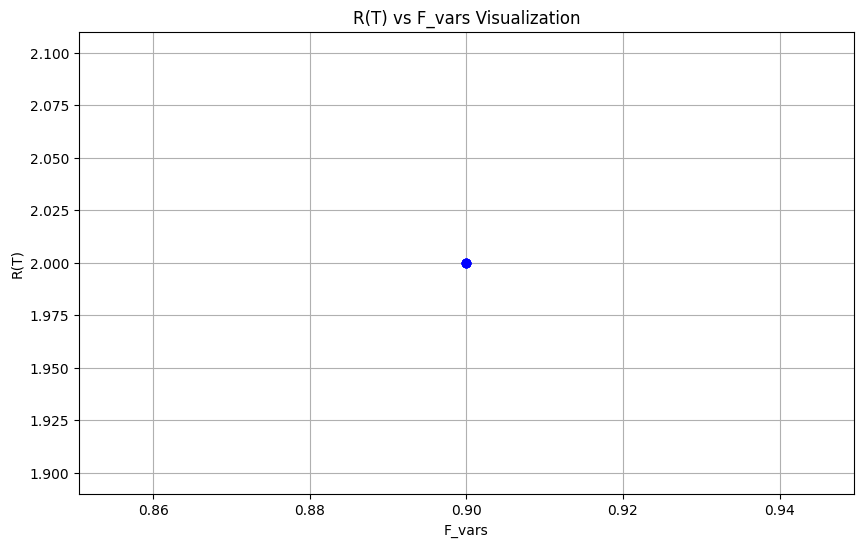

In [319]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [320]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 300 rows, 375 columns and 895 nonzeros
Model fingerprint: 0x8410e3c5
Model has 50 quadratic constraints
Model has 95 general constraints
Variable types: 300 continuous, 75 integer (70 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 58 rows and 6219 columns
Presolve time: 0.03s
Presolved: 1948 rows, 6969 columns, 24162 nonzeros
Presolved model has 45 SOS c

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/104858953.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)



Root relaxation: objective 4.869043e+05, 278 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 486904.320    0  303          - 486904.320      -     -    0s
     0     0 486904.320    0  303          - 486904.320      -     -    0s
     0     0 486904.320    0  371          - 486904.320      -     -    0s
     0     0 486904.320    0  368          - 486904.320      -     -    0s
     0     0 486904.320    0  368          - 486904.320      -     -    0s
     0     2 486904.320    0  368          - 486904.320      -     -    0s
  4910  2266 486904.320   90   67          - 486904.320      -  23.6    5s
  4921  2276 486904.320   13  507          - 486904.320      -  31.7   12s
  5404  2867 486904.320   33  289          - 486904.320      -  56.5   15s
  8663  3947 486904.320   33  332          - 486904.320      -  81.0   20s
 16502  5

In [321]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [322]:
stimulation_results_df_5

In [323]:
stimulation_results_df_5_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_5, Q_star, Qk_hat_df_train
)
stimulation_results_df_5_selected

In [324]:
rounded_difference_df

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [325]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 300 rows, 346 columns and 955 nonzeros
Model fingerprint: 0x390cbd09
Model has 45 quadratic constraints
Model has 90 general constraints
Variable types: 271 continuous, 75 integer (70 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 53 rows and 5467 columns
Presolve time: 0.03s
Presolved: 563 rows, 5828 columns, 17932 nonzeros
Presolved model has 40 SOS co

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3055309810.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


H  716   451                    452574.61517 486904.320  7.59%   5.9    0s
H  760   451                    477589.31896 486904.320  1.95%   5.9    0s
H  775   451                    486904.32015 486904.320  0.00%   5.8    0s

Cutting planes:
  MIR: 2
  Flow cover: 2
  RLT: 11
  Relax-and-lift: 1

Explored 855 nodes (5503 simplex iterations) in 0.38 seconds (0.30 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 486904 477589 452575 

Optimal solution found (tolerance 1.00e+00)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 4.869043201514e+05, best bound 4.869043201514e+05, gap 0.0000%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 201.70698664246055
Alphas values:
alpha[0]: 0.29060129830687464
alpha[1]: 0.6670634734499047
alpha[2]: 2.7227625460538203
B

average_profits  average_losses  average_lefts  average_operation_profits  \
0      97380.86403             0.0       76.29578                97380.86403   

                                        alpha_values  \
0  [0.29060129830687464, 0.6670634734499047, 2.72...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [326]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s6_10_202411262226.pkl


In [327]:
stimulation_results_df_6_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_6, Q_star, Qk_hat_df_train
)
stimulation_results_df_6_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0   demand_up      Sold0s      Left0s  \
0  7  201.706987  0.789849  159.318145  120.111086  120.111086   39.207059   
1  2  201.706987  0.930755  187.739827   63.128066   28.401773  159.338054   
2  6  201.706987  0.885287  178.568553  137.360031  137.360031   41.208522   
3  6  201.706987  0.933515  188.296556  138.395997  138.395997   49.900559   
4  3  201.706987  0.882284  177.962882   86.138178   86.138178   91.824704   

   lost0s      Qk_hat     Qk_hat-Q0  ...  Left1s  lost1s  Q0-Sold0s(left0)  \
0     0.0  159.318145 -7.389644e-13  ...     0.0     0.0         39.207059   
1     0.0  228.701163  4.096134e+01  ...     0.0     0.0        159.338054   
2     0.0  219.529895  4.096134e+01  ...     0.0     0.0         41.208522   
3     0.0  188.296556  1.705303e-13  ...     0.0     0.0         49.900559   
4     0.0  177.962882  1.705303e-13  ...     0.0     0.0         91.824704   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0           -39.207059                 2.060574e-13   
1          -124.611761                 6.821210e-13   
2           -41.208522                 6.252776e-13   
3           -49.900559                -1.627143e-12   
4           -91.824704                 2.131628e-13   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                     -2.984279e-13              39.207059   
1                     -8.526513e-13             159.338054   
2                     -8.384404e-13              41.208522   
3                      1.556089e-12              49.900559   
4                     -2.842171e-13              91.824704   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                      2.060574e-13   
1                       0.0                      6.821210e-13   
2                       0.0                      6.252776e-13   
3                       0.0                      0.000000e+00   
4                       0.0                      2.131628e-13   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                           0.000000e+00  
1                           0.000000e+00  
2                           0.000000e+00  
3                           1.556089e-12  
4                           0.000000e+00  

[5 rows x 24 columns]

In [328]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                -0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                -0.0

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [329]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
#     holding_cost=holding_cost,
# )
# results_df_7

In [330]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [331]:
stimulation_results_df_7

In [332]:
stimulation_results_df_7_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_7, Q_star, Qk_hat_df_train
)
stimulation_results_df_7_selected

In [333]:
rounded_difference_df

#### S4 - Beta with softmax


In [334]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
    holding_cost=holding_cost,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 1
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 300 rows, 367 columns and 975 nonzeros
Model fingerprint: 0x846c271d
Model has 50 quadratic constraints
Model has 95 general constraints
Variable types: 292 continuous, 75 integer (70 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+06]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 5e+06]
  GenCon coe range [1e+00, 1e+00]
Presolve added 98 rows and 6283 columns
Presolve time: 0.03s
Presolved: 1373 rows, 6870 columns, 22487 nonzeros
Presolved model has 45 SOS c

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/853573315.py:265: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


     0     0 486904.317    0  171          - 486904.317      -     -    0s
     0     2 486904.317    0  171          - 486904.317      -     -    0s
  6038  2069 452467.664  139  241          - 485232.574      -  38.0    5s
 12848  4030 infeasible  406               - 485232.574      -  52.4   10s
*17564  4653             666    413459.68623 485232.574  17.4%  58.6   13s

Cutting planes:
  RLT: 9

Explored 17567 nodes (1030357 simplex iterations) in 13.52 seconds (24.05 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 413460 

Optimal solution found (tolerance 1.00e+00)
  Piecewise linearization of function constraints often causes big violation.
  Try to adjust the settings of the related parameters, such as FuncPieces.
Best objective 4.134596862274e+05, best bound 4.852325742013e+05, gap 17.3591%

model.status is optimal: True
model.status is TIME_LIMIT: False

===================== 找到最佳解 ==================
Q0_optimal（最佳總庫存量）: 201.70698664246055
Alphas

average_profits  average_losses  average_lefts  average_operation_profits  \
0     82691.937245        7.287115     187.730712               93594.493958   

                                   alpha_values  \
0  [1.0841373710297055, 0.0, 3.040915670562477]   

                                         beta_values  \
0  [[-2.411663998836808, 0.8500245834791792, -2.0...   

                                          tau_values  
0  [[-0.3658831726523895, -0.6442859179174448, -2...

In [335]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

Model parameters saved as models/linear_constraint_med_with_holding_cost_0_s4_10_202411262226.pkl


In [336]:
stimulation_results_df_4_selected, rounded_difference_df = organize_stimulation_result(
    stimulation_results_df_4, Q_star, Qk_hat_df_train
)
stimulation_results_df_4_selected

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["Q0-Sold0s(left0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation_df_selected["demand_up-Q0(lost0)"] = (
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/1770888325.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

R      Q_star         F          Q0  demand_up     Sold0s      Left0s  \
0  0  201.706987  0.842551  169.948367   7.169518   7.169518  162.778849   
1  0  201.706987  0.993307  200.356992  20.735939   0.000000  200.356992   
2  0  201.706987  0.908900  183.331391  15.418481   0.000000  183.331391   
3  0  201.706987  0.910301  183.614144  23.396067  23.396067  160.218077   
4  0  201.706987  0.880797  177.662955  18.284699  18.284699  159.378256   

   lost0s      Qk_hat  Qk_hat-Q0  ...     Left1s     lost1s  Q0-Sold0s(left0)  \
0     0.0  169.948367   0.000000  ...  10.630222   0.000000        162.778849   
1     0.0  213.772218  13.415226  ...   0.000000  28.919299        200.356992   
2     0.0  196.595139  13.263748  ...   0.000000   7.516275        183.331391   
3     0.0  222.365275  38.751131  ...  34.068719   0.000000        160.218077   
4     0.0  205.853934  28.190979  ...  27.891052   0.000000        159.378256   

   demand_up-Q0(lost0)  Q1_plus_lefts-Sold1s(left1)  \
0          -162.778849                    10.630222   
1          -179.621053                     0.000000   
2          -167.912910                     0.000000   
3          -160.218077                    34.068719   
4          -159.378256                    27.891052   

   demand_down-Q1_plus_lefts(lost1)  Q0-Sold0s(left0)_clip  \
0                        -10.630222             162.778849   
1                         28.919299             200.356992   
2                          7.516275             183.331391   
3                        -34.068719             160.218077   
4                        -27.891052             159.378256   

   demand_up-Q0(lost0)_clip  Q1_plus_lefts-Sold1s(left1)_clip  \
0                       0.0                         10.630222   
1                       0.0                          0.000000   
2                       0.0                          0.000000   
3                       0.0                         34.068719   
4                       0.0                         27.891052   

   demand_down-Q1_plus_lefts(lost1)_clip  
0                               0.000000  
1                              28.919299  
2                               7.516275  
3                               0.000000  
4                               0.000000  

[5 rows x 24 columns]

In [337]:
rounded_difference_df

Metric  Average Difference
0                  Left0s - Q0-Sold0s(left0)                 0.0
1               Lost0s - demand_up-Q0(lost0)                 0.0
2       Left1s - Q1_plus_lefts-Sold1s(left1)                 0.0
3  Lost1s - demand_down-Q1_plus_lefts(lost1)                 0.0

### Analysis


#### Baseline


In [338]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 76990.48013669127


#### S1


In [339]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
42     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
41     6  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
33     5  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
32     5  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
31     5  0.5  [100.85349332123027, 100.85349332123027, 100.8...   
..   ...  ...                                                ...   
55     8  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
65     9  0.3  [60.512095992738175, 60.512095992738175, 60.51...   
54     8  0.1  [20.170698664246057, 20.170698664246057, 20.17...   
64     9  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
63     9  0.1  [20.170698664246057, 20.170698664246057, 20.17...   

                                                   Q1  average_profits  \
42  [18.123253971166548, 122.23256524550888, 78.33...    100853.493321   
41  [38.293952635412595, 142.4032639097549, 98.505...    100853.493321   
33  [18.123253971166463, 122.23256524550877, 78.33...    100853.493321   
32  [38.29395263541251, 142.4032639097548, 98.5057...    100853.493321   
31  [58.464651299658584, 162.5739625740009, 118.67...    100853.493321   
..                                                ...              ...   
55  [118.97674729239685, 223.0860585667392, 179.18...    -40036.581445   
65  [98.80604862815082, 202.91535990249315, 159.01...    -44212.300990   
54  [139.1474459566429, 243.25675723098527, 199.35...    -70292.629442   
64  [118.97674729239688, 223.0860585667392, 179.18...    -74468.348986   
63  [139.14744595664294, 243.25675723098527, 199.3...   -104724.396983   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
42    2.557954e-14   5.684342e-15              100853.493321     76990.480137   
41    3.126388e-14   5.684342e-15              100853.493321     76990.480137   
33    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
32    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
31    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
..             ...            ...                        ...              ...   
55    9.392672e+01   9.392672e+01               53890.135066     76990.480137   
65    9.671053e+01   9.671053e+01               52498.228551     76990.480137   
54    1.140974e+02   1.140974e+02               43804.785734     76990.480137   
64    1.168812e+02   1.168812e+02               42412.879219     76990.480137   
63    1.370519e+02   1.370519e+02               32327.529887     76990.480137   

    profit_diff_percent  
42            30.994758  
41            30.994758  
33            30.994758  
32            30.994758  
31            30.994758  
..                  ...  
55          -152.001990  
65          -157.425673  
54          -191.300417  
64          -196.724100  
63          -236.022527  

[72 rows x 10 columns]

In [340]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]

    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1最佳策略在：R=6, F=0.7000000000000001
策略1最佳策略之下最大利潤為：100853.49332123026


#### S2


In [341]:
results_df_2

R(T)                R  average_profits  average_losses  average_lefts  \
1     3  [1, 1, 1, 1, 1]     87763.606881        8.390961     150.184371   
2     4  [2, 2, 2, 2, 2]     86670.312694        9.455454     128.648899   
0     2  [0, 0, 0, 0, 0]     79076.495232       14.517999     177.191634   

   average_operation_profits  \
1               96658.012834   
2               96125.766445   
0               93594.493958   

                                        alpha_values  \
1        [0.0, 3.495266477455761, 6.068219576717649]   
2        [0.6506216631922249, 0.0, 2.16897286678918]   
0  [0.11744596076574089, 0.24580096037453592, 2.2...   

                                              F_vars  \
1  [0.7898494111326531, 0.9141798059199618, 0.866...   
2  [0.7710777908182428, 0.9627212450477464, 0.857...   
0  [0.8425507213543845, 0.9277310253708273, 0.903...   

                                             Q0_vars  \
1  [159.31814462088937, 184.3964539015049, 174.68...   
2  [155.53177765287327, 194.18760131525875, 172.9...   
0  [169.9483670978243, 187.12982954226968, 182.22...   

                                             Q1_vars  
1  [0.0, 40.961237031371454, 40.96116181241634, 0...  
2  [0.0, 34.513561670475035, 37.805514894698476, ...  
0  [0.0, 26.642388377190855, 14.367306685928652, ...

In [342]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]

    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2最佳策略在：R=3, F為彈性
策略2最佳策略之下最大利潤為：87763.6068809481


#### S3


In [343]:
# 策略三
results_df_3

R(T)  average_losses  average_lefts  average_operation_profits  \
0  [2, 2, 2, 2, 2]        7.287115     188.601814               93594.493958   

   average_profits                                        beta_values  \
0     81533.145157  [[-1.6372765099501552, -0.12721868937562453, -...   

                      F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9]   

                                             Q0_vars  \
0  [181.5362879782145, 181.5362879782145, 181.536...   

                                             Q1_vars  \
0  [0.0, 32.23592994124604, 15.058851037670337, 4...   

                                          tau_values  
0  [[-1.6978553778795984, -2.221787763552398, -0....

In [344]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = results_df_3.iloc[0]
    max_profit_for_s3 = max_profit_row["average_profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['F_vars'][0]}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

策略3最佳策略在：
R=0.9
策略3最佳策略之下最大利潤(Avg profit)為：81533.14515744345


#### S4


In [345]:
results_df_4

average_profits  average_losses  average_lefts  average_operation_profits  \
0     82691.937245        7.287115     187.730712               93594.493958   

                                   alpha_values  \
0  [1.0841373710297055, 0.0, 3.040915670562477]   

                                         beta_values  \
0  [[-2.411663998836808, 0.8500245834791792, -2.0...   

                                          tau_values  
0  [[-0.3658831726523895, -0.6442859179174448, -2...

In [346]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

策略4最佳策略之下最大利潤(Avg profit)為：82691.93724547813


#### S5


In [347]:
results_df_5

In [348]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = results_df_5.loc[results_df_5["average_profits"].idxmax()]
    max_profit_for_s5 = max_profit_row["average_profits"]

    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [349]:
results_df_6

average_profits  average_losses  average_lefts  average_operation_profits  \
0      97380.86403             0.0       76.29578                97380.86403   

                                        alpha_values  \
0  [0.29060129830687464, 0.6670634734499047, 2.72...   

                                         beta_values  \
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....   

                                          tau_values  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....

In [350]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = results_df_6.loc[results_df_6["average_profits"].idxmax()]
    max_profit_for_s6 = max_profit_row["average_profits"]

    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

策略6最佳策略之下最大利潤(Avg profit)為：97380.86403028053


#### S7


In [351]:
results_df_7

In [352]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = results_df_7.loc[results_df_7["average_profits"].idxmax()]
    max_profit_for_s7 = max_profit_row["average_profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [353]:
results_df_8

R(T)    F                                                 Q0  \
42     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
41     6  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
33     5  0.7  [141.1948906497224, 141.1948906497224, 141.194...   
32     5  0.6  [121.02419198547635, 121.02419198547635, 121.0...   
31     5  0.5  [100.85349332123027, 100.85349332123027, 100.8...   
..   ...  ...                                                ...   
55     8  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
65     9  0.3  [60.512095992738175, 60.512095992738175, 60.51...   
54     8  0.1  [20.170698664246057, 20.170698664246057, 20.17...   
64     9  0.2  [40.341397328492114, 40.341397328492114, 40.34...   
63     9  0.1  [20.170698664246057, 20.170698664246057, 20.17...   

                                                   Q1  average_profits  \
42  [18.123253971166548, 122.23256524550888, 78.33...    100853.493321   
41  [38.293952635412595, 142.4032639097549, 98.505...    100853.493321   
33  [18.123253971166463, 122.23256524550877, 78.33...    100853.493321   
32  [38.29395263541251, 142.4032639097548, 98.5057...    100853.493321   
31  [58.464651299658584, 162.5739625740009, 118.67...    100853.493321   
..                                                ...              ...   
55  [118.97674729239685, 223.0860585667392, 179.18...    -40036.581445   
65  [98.80604862815082, 202.91535990249315, 159.01...    -44212.300990   
54  [139.1474459566429, 243.25675723098527, 199.35...    -70292.629442   
64  [118.97674729239688, 223.0860585667392, 179.18...    -74468.348986   
63  [139.14744595664294, 243.25675723098527, 199.3...   -104724.396983   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
42    2.557954e-14   5.684342e-15              100853.493321     76990.480137   
41    3.126388e-14   5.684342e-15              100853.493321     76990.480137   
33    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
32    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
31    1.250555e-13   9.947598e-14              100853.493321     76990.480137   
..             ...            ...                        ...              ...   
55    9.392672e+01   9.392672e+01               53890.135066     76990.480137   
65    9.671053e+01   9.671053e+01               52498.228551     76990.480137   
54    1.140974e+02   1.140974e+02               43804.785734     76990.480137   
64    1.168812e+02   1.168812e+02               42412.879219     76990.480137   
63    1.370519e+02   1.370519e+02               32327.529887     76990.480137   

    profit_diff_percent  
42            30.994758  
41            30.994758  
33            30.994758  
32            30.994758  
31            30.994758  
..                  ...  
55          -152.001990  
65          -157.425673  
54          -191.300417  
64          -196.724100  
63          -236.022527  

[72 rows x 10 columns]

In [354]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = results_df_8.loc[results_df_8["average_profits"].idxmax()]
    max_profit_for_s8 = max_profit_row["average_profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=6, 
F=0.7000000000000001
策略8最佳策略之下最大利潤(Avg profit)為：100853.49332123026


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


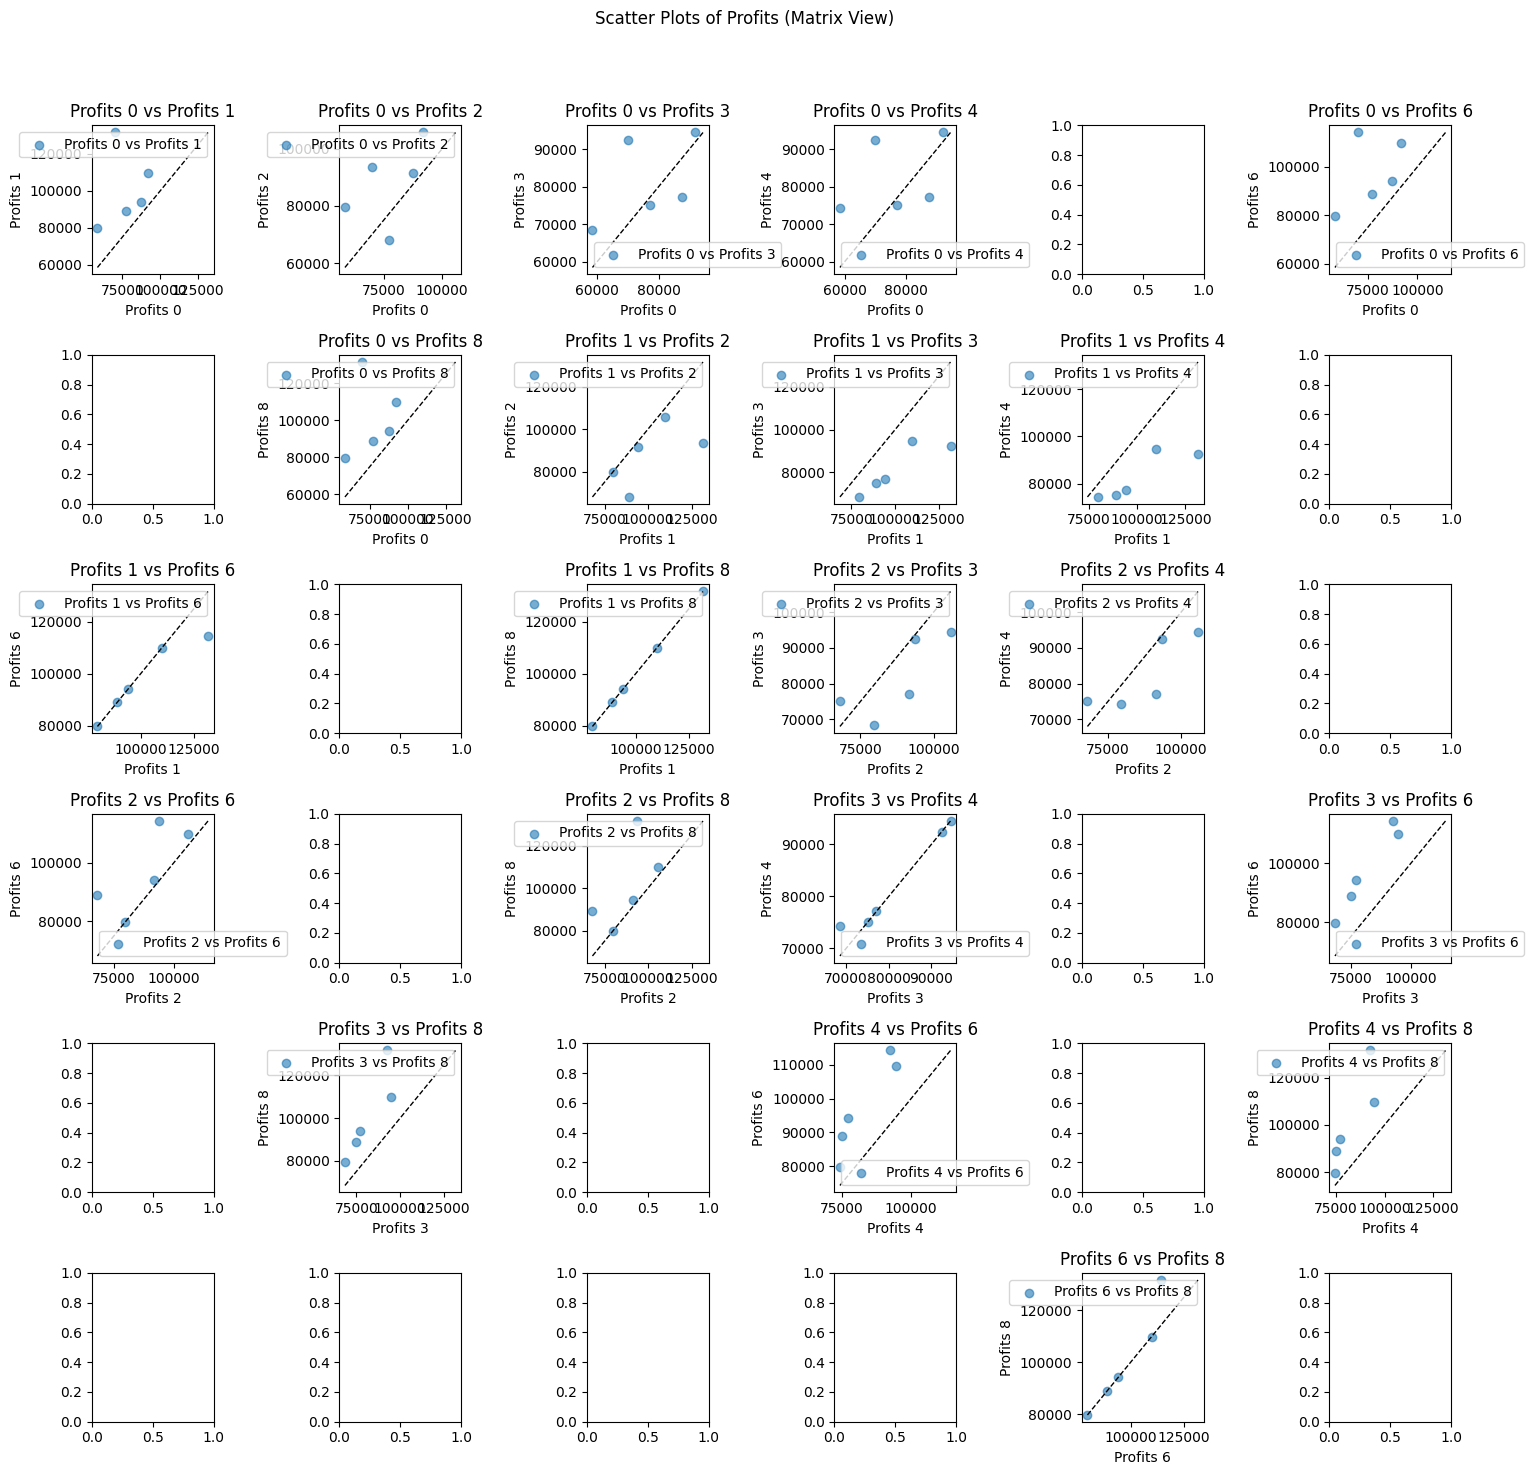

In [355]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S1_202411262226.png


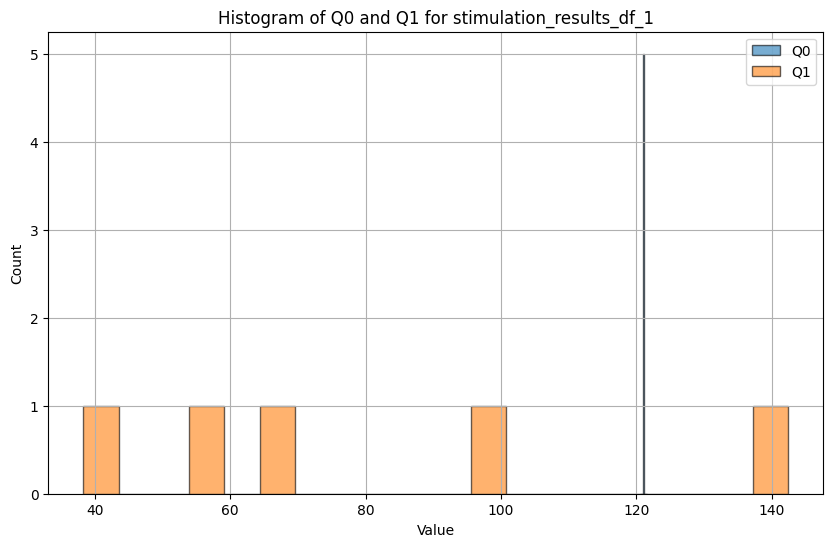

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S2_202411262226.png


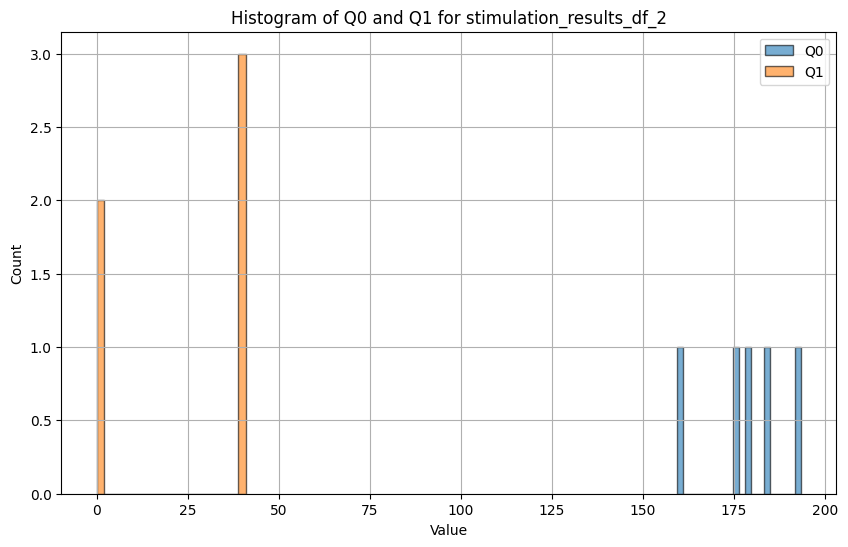

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S3_202411262226.png


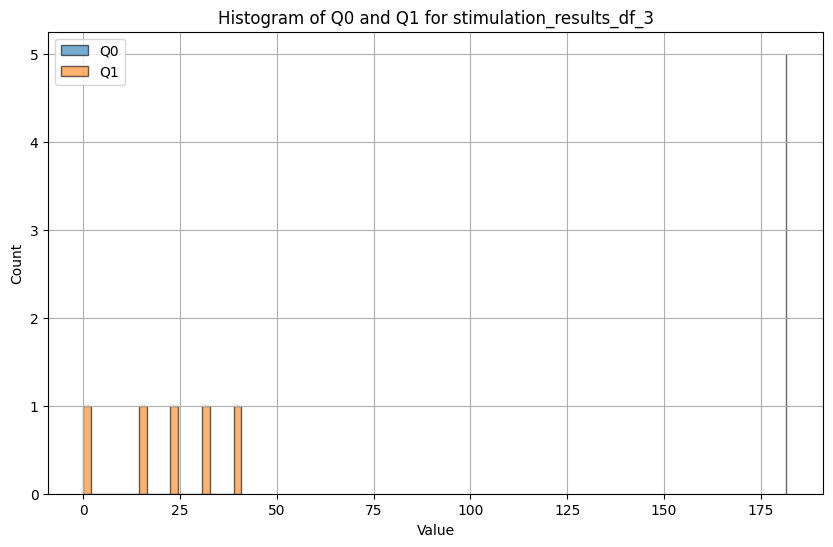

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S4_202411262226.png


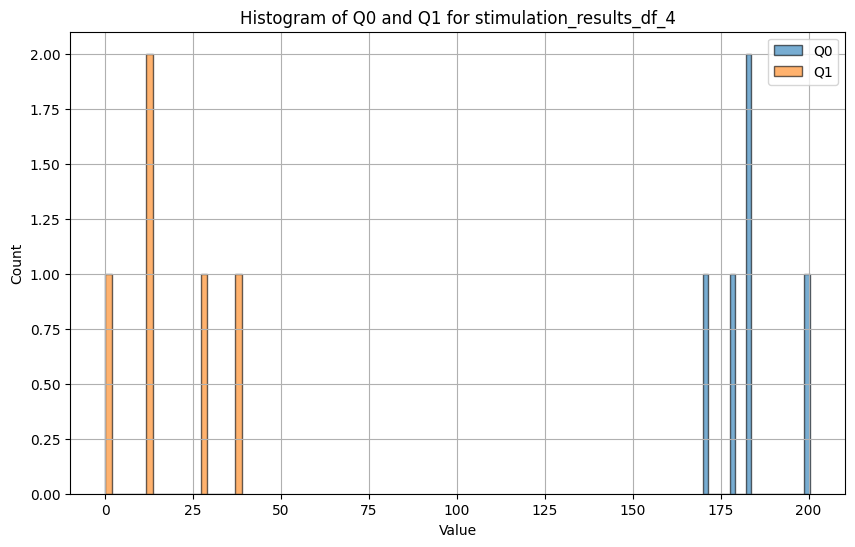

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S6_202411262226.png


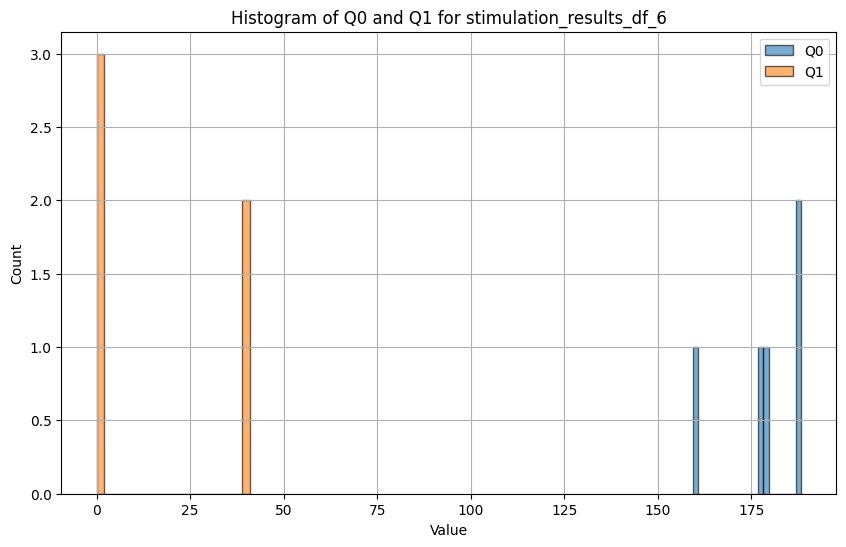

Plot saved as plots/plot_Q0_Q1_distribution_train_linear_constraint_med_with_holding_cost_0_10_S8_202411262226.png


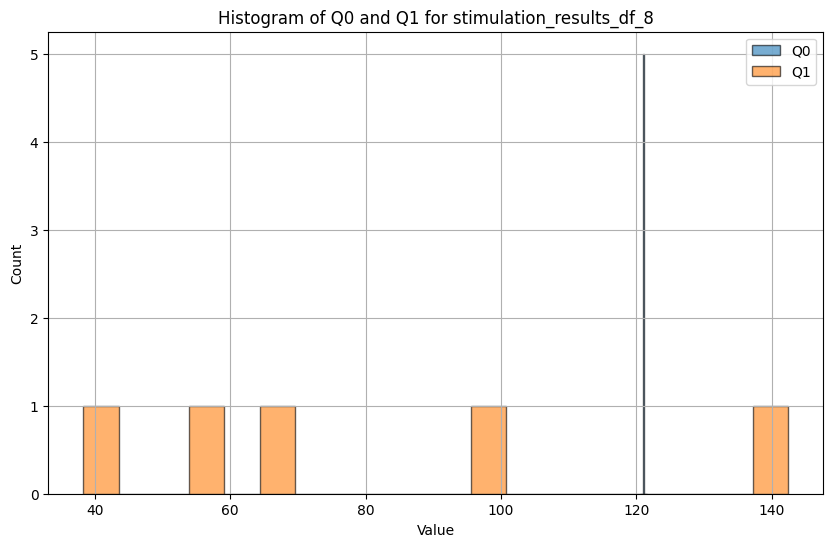

In [356]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S1_202411262226.png


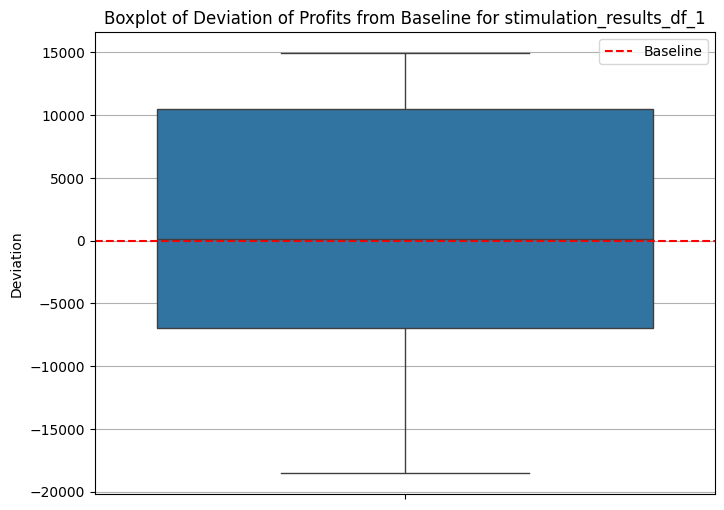

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S2_202411262226.png


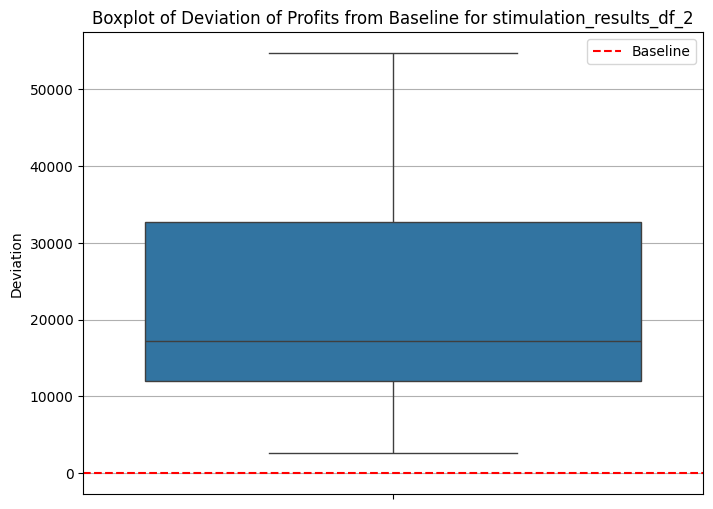

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S3_202411262226.png


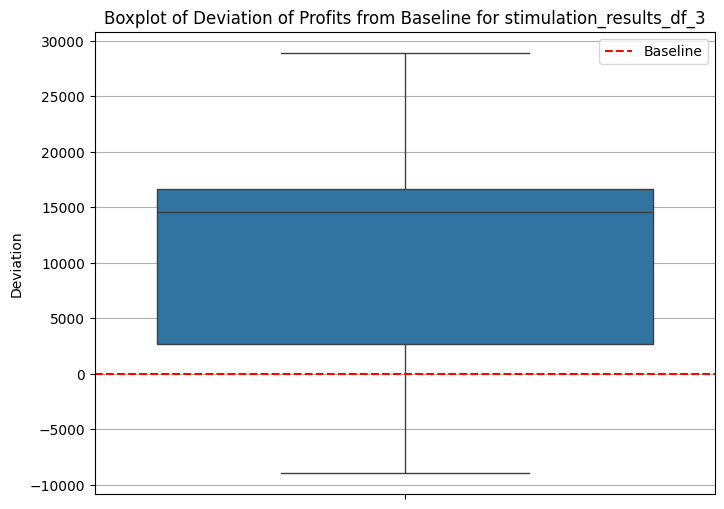

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S4_202411262226.png


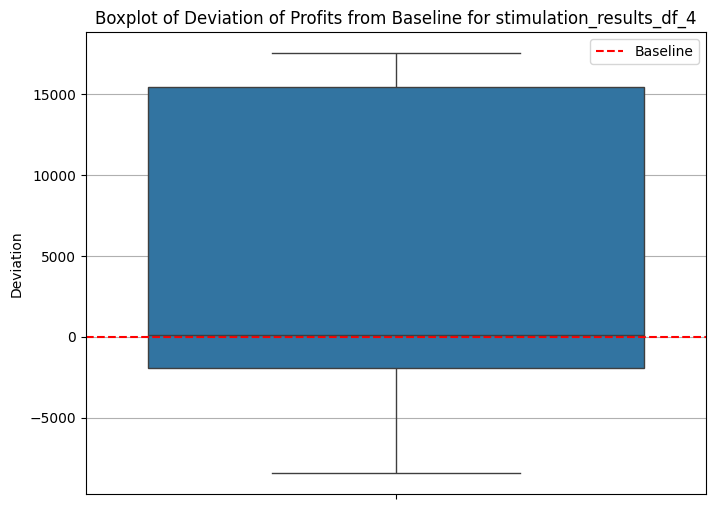

Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S5_202411262226.png


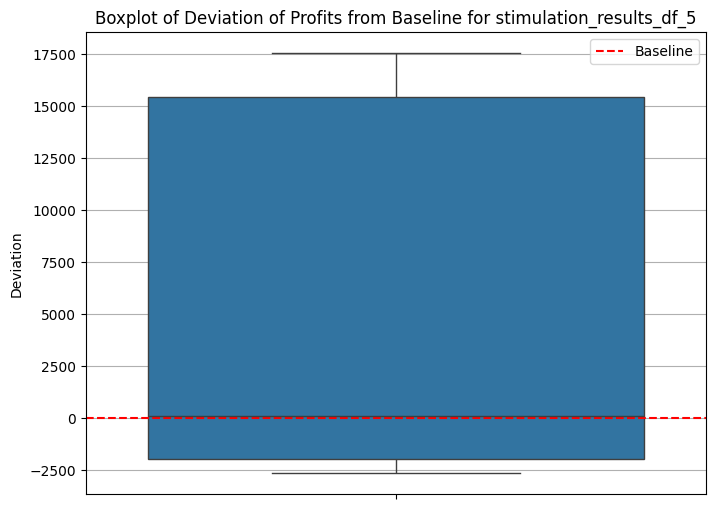

Skipping stimulation_results_df_6: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S7_202411262226.png


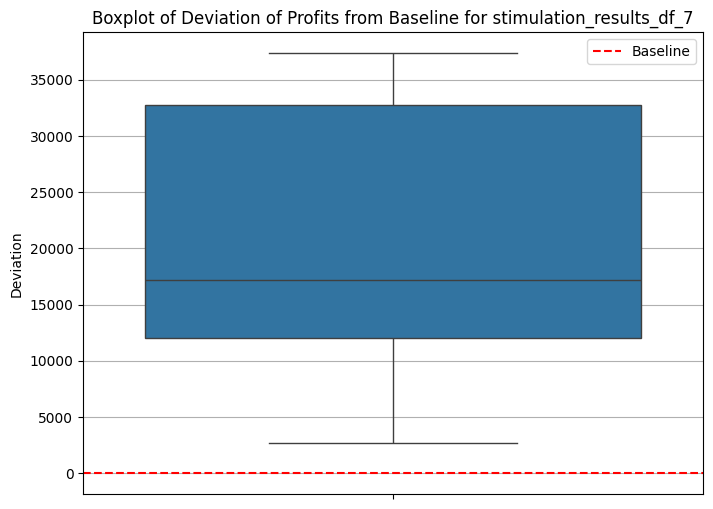

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_linear_constraint_med_with_holding_cost_0_10_S9_202411262226.png


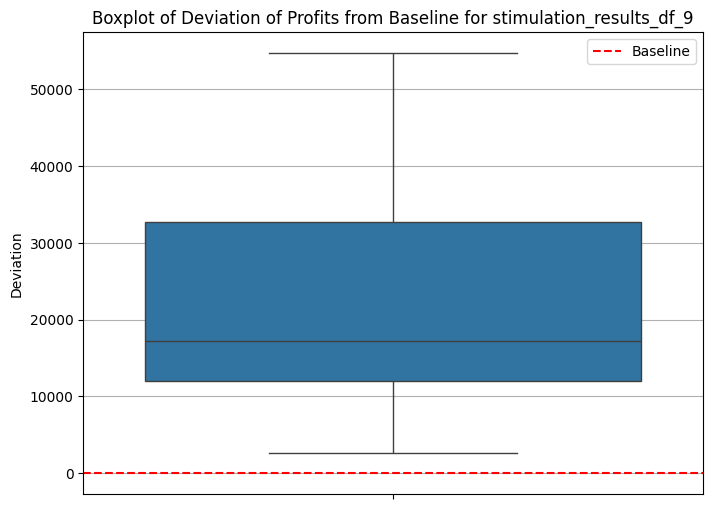

In [357]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 76990.48013669127
S1's profit: 100853.49332123026
S2's profit: 87763.6068809481
S3's profit: 81533.14515744345
S4's profit: 82691.93724547813
S5's profit: -1
S6's profit: 97380.86403028053
S7's profit: -1
S8's profit: 100853.49332123026
Plot saved as plots/plot_relative_profit_deviation_train_linear_constraint_med_with_holding_cost_0_10_202411262226.png


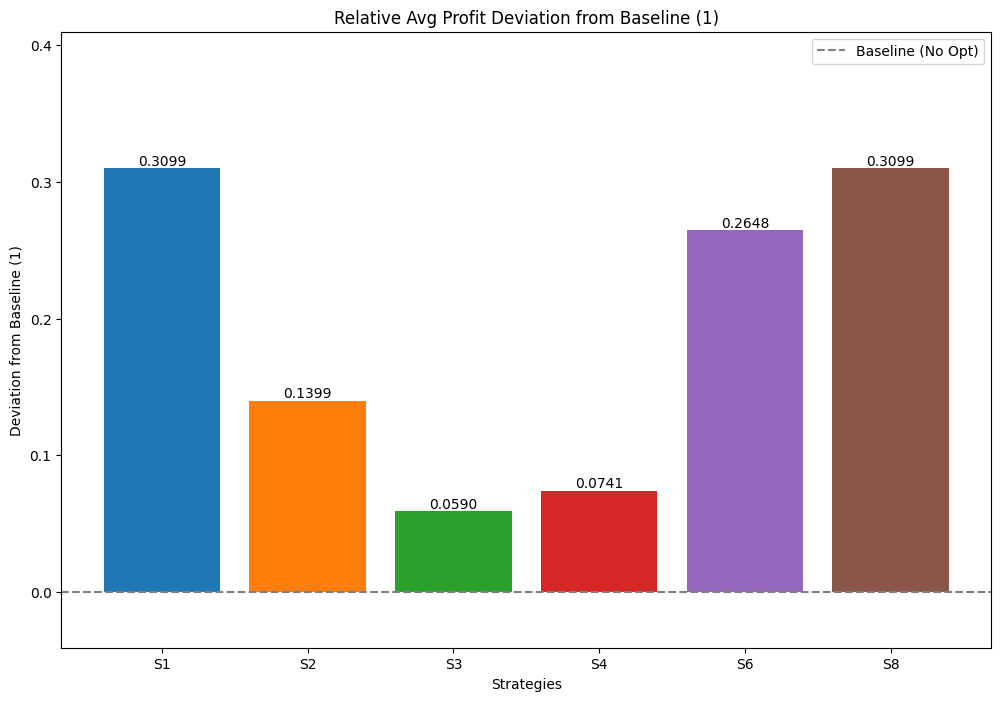

In [358]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [359]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [360]:
status = "test"

In [361]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 201.70698664246055
std of sum: 40.82740642155722
50.0 percentile of sum: 201.70698664246055
Q_star: 201.70698664246055


In [362]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (5, 8)


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  257.018405  256.843116  228.033581  228.084686  228.084686  228.084686   
1  227.471313  222.509322  247.919129  247.873019  247.873019  247.873019   
2  110.332539  107.060770   95.668050   95.736360   95.736360   95.736360   
3  171.526841  174.810389  170.499631  170.293663  170.293663  170.293663   
4  189.548129  194.673629  213.776836  213.909499  213.909499  213.909499   

    Qk_hat_k8   Qk_hat_k9  
0  228.084686  228.084686  
1  247.873019  247.873019  
2   95.736360   95.736360  
3  170.293663  170.293663  
4  213.909499  213.909499

### Run all the strategies


Baseline

In [363]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    holding_cost=holding_cost,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/5 with initial inventory Q_star=201.70698664246055
--------------------------------------------------
Day 1
Demand      : 42.982653649169734
Sales       : 42.982653649169734
Loss        : 0
Left        : 158.72433299329083
Inventory   : 158.72433299329083
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 31.149574953934554
Sales       : 31.149574953934554
Loss        : 0
Left        : 127.57475803935628
Inventory   : 127.57475803935628
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 42.427934642192554
Sales       : 42.427934642192554
Loss        : 0
Left        : 85.14682339716373
Inventory   : 85.14682339716373
Holding Cost: 0.0
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 26.74387651007689
Sales       : 26.743876

In [364]:
test_stimulation_df_baseline.head()

losses       lefts  operation_profits       profits
0  26.377699    0.000000      100853.493321  87664.643753
1  46.166033    0.000000      100853.493321  77770.477014
2   0.000000  105.970627       47868.180057  -5117.133207
3   0.000000   31.413324       85146.831359  69440.169396
4  12.202512    0.000000      100853.493321  94752.237225

S1

In [365]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.7000000000000001, R: 6
Q_star 為 201.70698664246055
期初庫存 Q0: 141.1948906497224
重新估計量 Qk_hat: 228.08468577963754
訂貨量 Q1 為 86.88979512991514

第一階段：期初庫存 Q0: 141.1948906497224，需求量為 152.47492547973627，Sold_0 為 141.1948906497224，Left_0 為 0.0，Lost_0 為 11.280034830013875
第二階段：期初庫存 Q1+left_0 為 86.88979512991514，需求量為 75.60976029990127，Sold_1 為 75.60976029990127，Left_1 為 11.280034830013875，Lost_1 為 0

統計結果：Sold 為 216.80465094962366, Lost 為 11.280034830013875 Left_Penalty_Cost 為 5640.017415006938，Lost_Penalty_Cost 為 5640.017415006938，Profit 為 97122.29064479796
----------------------------------------
這是第 2 筆模擬資料

F: 0.7000000000000001, R: 6
Q_star 為 201.70698664246055
期初庫存 Q0: 141.1948906497224
重新估計量 Qk_hat: 247.8730192570856
訂貨量 Q1 為 106.67812860736319

第一階段：期初庫存 Q0: 141.1948906497224，需求量為 124.08428403413768，Sold_0 為 124.08428403413768，Left_0 為 17.110606615584715，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 123.7887352229479，需求量為 123.7887352229479，Sold_1 為 123.7887352229479，Left_1 為 0.0，

R(T)    F                                                 Q0  \
0     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   

                                                  Q1  average_profits  \
0  [86.88979512991514, 106.67812860736319, 0, 29....     87659.859168   

   average_losses  average_lefts  average_operation_profits  
0        2.256007      11.347713               94461.719187

S2

In [366]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_2

assigned_R: 1


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3758896648.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     73828.808162   6339.579361   6339.579361   

                                  alpha_values  R(T)  
0  [0.0, 3.495266477455761, 6.068219576717649]     3

S3

In [367]:
results_df_3.head()

R(T)  average_losses  average_lefts  average_operation_profits  \
0  [2, 2, 2, 2, 2]        7.287115     188.601814               93594.493958   

   average_profits                                        beta_values  \
0     81533.145157  [[-1.6372765099501552, -0.12721868937562453, -...   

                      F_vars  \
0  [0.9, 0.9, 0.9, 0.9, 0.9]   

                                             Q0_vars  \
0  [181.5362879782145, 181.5362879782145, 181.536...   

                                             Q1_vars  \
0  [0.0, 32.23592994124604, 15.058851037670337, 4...   

                                          tau_values  
0  [[-1.6978553778795984, -2.221787763552398, -0....

In [368]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    print(f"betas: {betas}")
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
        holding_cost=holding_cost,
    )

test_results_df_3

betas: [[-1.63727651 -0.12721869 -3.73868074]
 [-2.81556767  1.80131414 -3.10402955]
 [ 0.03196244 -0.07355114 -0.09089696]
 [ 3.25105946 -4.24191546 -6.18981336]
 [ 0.01029892 -0.08072956 -0.09340313]
 [ 0.76228557 -4.81309298 -5.75581747]
 [-4.50246745  0.19832382 -5.2572026 ]
 [ 1.77437812  0.67461906 -3.7232401 ]]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/2776381693.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     85885.467358  7.105427e-12  7.105427e-12   

                                         beta_balues    F  
0  [[-1.6372765099501552, -0.12721868937562453, -...  0.9

In [369]:
test_stimulation_results_df_3

F  R(T)      Sold_0      Left_0  Lost_0     Sold_1        Left_1  \
0  0.9     5  143.304040   38.232248     0.0  84.780646  0.000000e+00   
1  0.9     8  166.909620   14.626668     0.0  80.963399  4.263256e-14   
2  0.9     9   87.208219   94.328069     0.0   8.528141  8.579993e+01   
3  0.9     5   81.200503  100.335785     0.0  89.093160  1.124263e+01   
4  0.9     8  157.854896   23.681392     0.0  56.054603  0.000000e+00   

         Lost_1        profits          Q0         Q1          hc0         hc1  
0  1.136868e-13  114042.342890  181.536288  46.548398   532.633868  211.951615  
1  0.000000e+00  123936.509629  181.536288  66.336731   918.748905   80.963399  
2  0.000000e+00    4968.216125  181.536288   0.000000  1103.457429   90.063999  
3  0.000000e+00   79525.518728  181.536288   0.000000   563.744146  278.946026  
4  1.421085e-14  106954.749417  181.536288  32.373211   831.568117   56.054603

S4

In [370]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_4

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/3946604441.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     80663.076179   8406.124534   8406.124534   

                                   alpha_values  \
0  [1.0841373710297055, 0.0, 3.040915670562477]   

                                         beta_balues  
0  [[-2.411663998836808, 0.8500245834791792, -2.0...

In [371]:
# import numpy as np

# # Provided data
# betas = np.array(
#     [
#         [0.00000000e00, 0.00000000e00, -8.94906903e-02],
#         [-3.13562128e-02, 4.00627944e-03, -6.21189321e-02],
#         [3.97911689e-02, 1.78930917e-02, -4.96275009e-02],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [0.00000000e00, 0.00000000e00, 0.00000000e00],
#         [3.50517907e-05, 1.43159496e-03, -3.20821046e-03],
#     ]
# )
# X_data = np.array([1.4397189210284136, -0.794923445271338, 1])

# # Initialization
# features_num = len(X_data)
# tau_vars = np.zeros((1, len(betas)))  # Assuming one data point for simplicity
# exp_tau_vars = np.zeros_like(tau_vars)
# r_vars = np.zeros_like(tau_vars)
# R_vars = np.zeros_like(tau_vars)

# # Calculate tau_vars
# for k in range(len(betas)):
#     tau_vars[0, k] = sum(X_data[j] * betas[k, j] for j in range(features_num))

# # Step 2: Calculate the exponentials of -tau_vars
# exp_tau_vars[0] = np.exp(-tau_vars[0])

# # Step 3: Softmax normalization
# sum_exp_tau = np.sum(exp_tau_vars[0])  # Sum of exponentials for normalization
# r_vars[0] = exp_tau_vars[0] / sum_exp_tau  # Normalize to get softmax

# # Step 4: Find the index of the maximum r_var and set R_vars
# max_r_index = np.argmax(r_vars[0])
# R_vars[0, max_r_index] = 1

# print(f"tau_vars: {tau_vars}")
# print(f"exp_tau_vars: {exp_tau_vars}")
# print(f"r_vars: {r_vars}")
# print(f"R_vars: {R_vars}")

# # Print the final R matrix
# print("Final R matrix:")
# print(R_vars)

In [372]:
test_stimulation_results_df_4

F  R(T)      Sold_0      Left_0  Lost_0      Sold_1        Left_1  \
0  0.950884     7  161.737960   30.061957     0.0   66.346726  5.684342e-14   
1  0.995957     2   37.316315  163.575110     0.0  190.154998  0.000000e+00   
2  0.845657     7   79.736716   90.838199     0.0   15.999644  7.483855e+01   
3  0.804951     7  116.555779   45.808533     0.0   53.737884  8.526513e-14   
4  0.977146     2   30.043667  167.053583     0.0  167.053583  0.000000e+00   

      Lost_1        profits          Q0         Q1         hc0         hc1  
0   0.000000  114042.342890  191.799917  36.284769  774.439928   99.520089  
1  20.401706  103534.803444  200.891425  26.579888  195.523212  760.619992  
2   0.000000   10448.902854  170.574915   0.000000  784.239339  248.515129  
3   0.000000   85146.831359  162.364312   7.929350  648.306588   80.606826  
4  16.812249   90142.500350  197.097250   0.000000  182.075416  668.214331

S5

In [373]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_5

In [374]:
test_stimulation_results_df_5

S6

In [375]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_6

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_60930/492182808.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0     74881.959488  11311.672388  11311.672388   

                                        alpha_values  \
0  [0.29060129830687464, 0.6670634734499047, 2.72...   

                                         beta_balues  
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....

In [376]:
test_stimulation_results_df_6

F  R(T)     Sold_0      Left_0  Lost_0      Sold_1     Left_1  \
0  0.940700     2  42.982654  146.763162     0.0  185.102032  28.933719   
1  0.978169     2  37.316315  159.987176     0.0  190.154998   0.000000   
2  0.829523     2  14.852244  152.468275     0.0   80.884116  71.584160   
3  0.945943     2  26.587668  164.215646     0.0  143.705995  20.509651   
4  0.948337     2  30.043667  161.242487     0.0  161.242487   0.000000   

      Lost_1        profits          Q0         Q1         hc0         hc1  
0   0.000000   99575.483289  189.745815  67.272590  201.890783  971.877882  
1  20.401706  103534.803444  197.303491  30.167822  193.729245  760.619992  
2   0.000000   12076.100197  167.320520   0.000000  159.894398  896.209741  
3   0.000000   74892.005870  190.803314   0.000000  177.509480  738.901187  
4  22.623345   84331.404641  191.286154   0.000000  176.264321  644.969949

S7

In [377]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
            holding_cost=holding_cost,
        )
    )

test_results_df_7

S8

In [378]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

R(T)    F                                                 Q0  \
0     6  0.7  [141.1948906497224, 141.1948906497224, 141.194...   

                                                  Q1  average_profits  \
0  [86.88979512991514, 106.67812860736319, 0, 29....     87659.859168   

   average_losses  average_lefts  average_operation_profits  
0        2.256007      11.347713               94461.719187

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_linear_constraint_med_with_holding_cost_0_10_202411262226.png


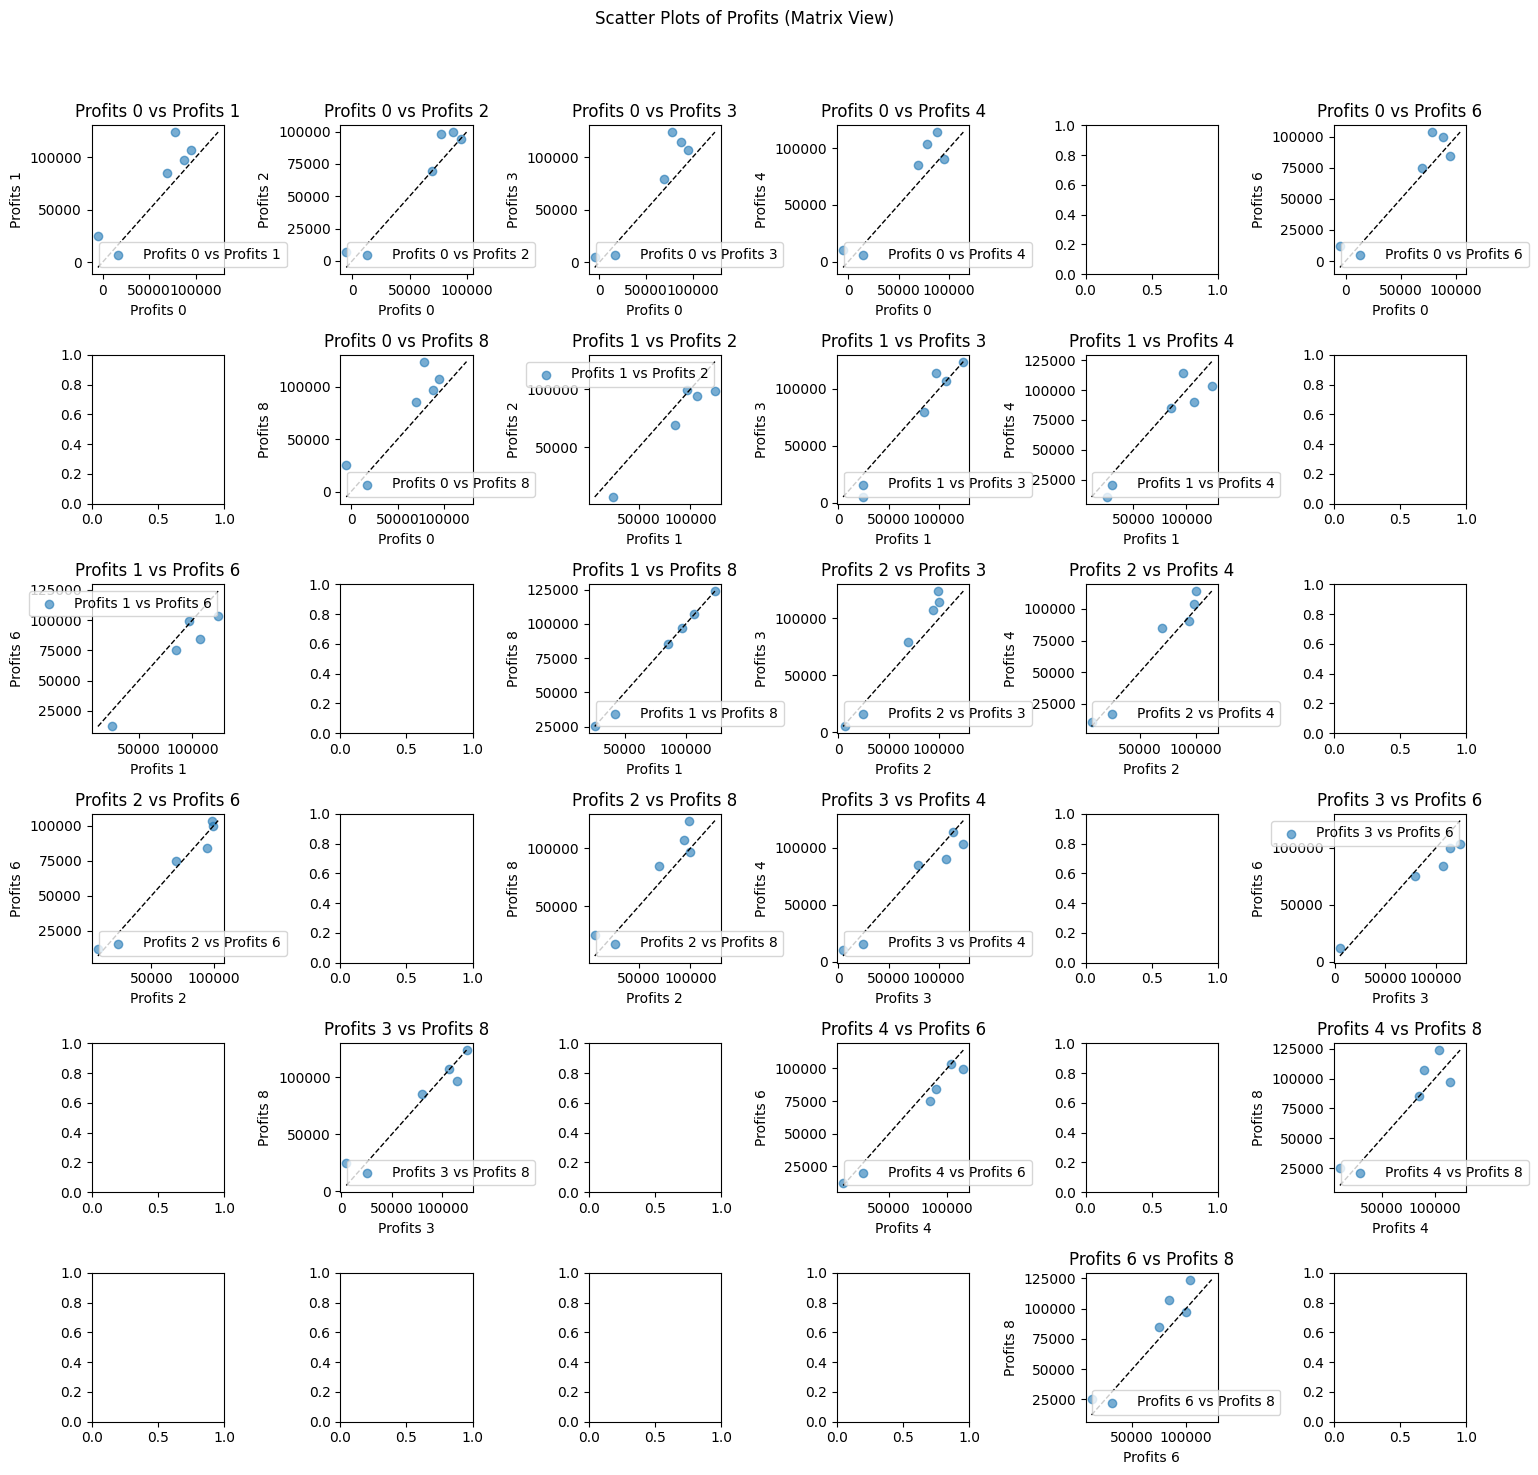

In [379]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 64902.07883619337
S1's profit: 87659.85916777267
S2's profit: 73828.80816246124
S3's profit: 85885.46735785862
S4's profit: 80663.07617928232
S5's profit: -1
S6's profit: 74881.9594881964
S7's profit: -1
S8's profit: 87659.85916777267
Plot saved as plots/plot_relative_profit_deviation_test_linear_constraint_med_with_holding_cost_0_10_202411262226.png


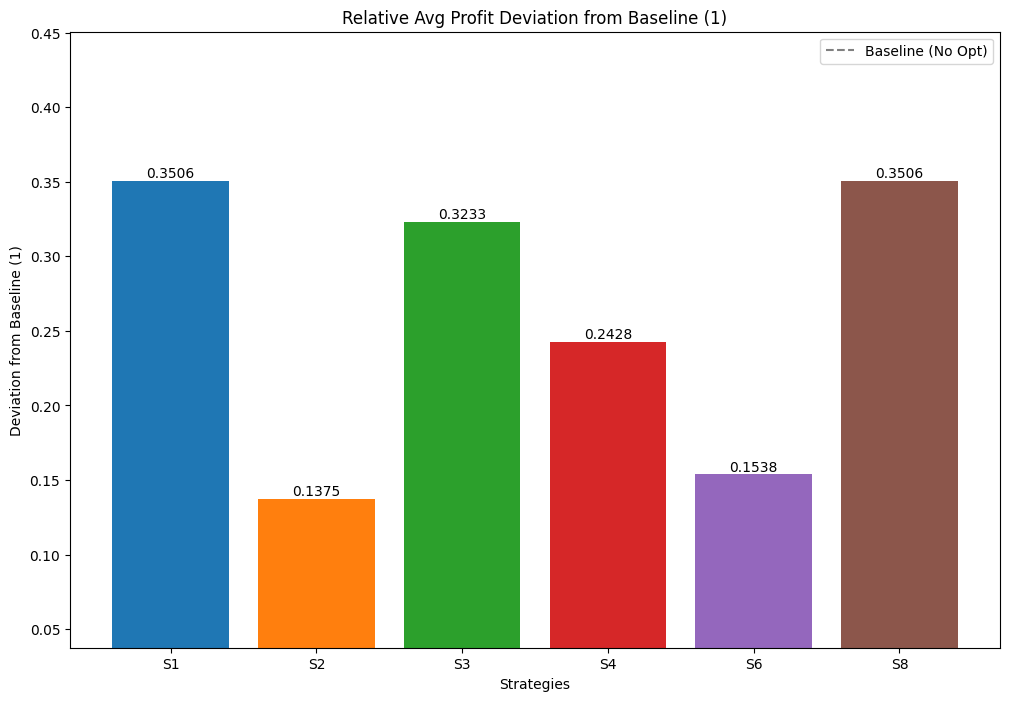

In [380]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S1_202411262226.png


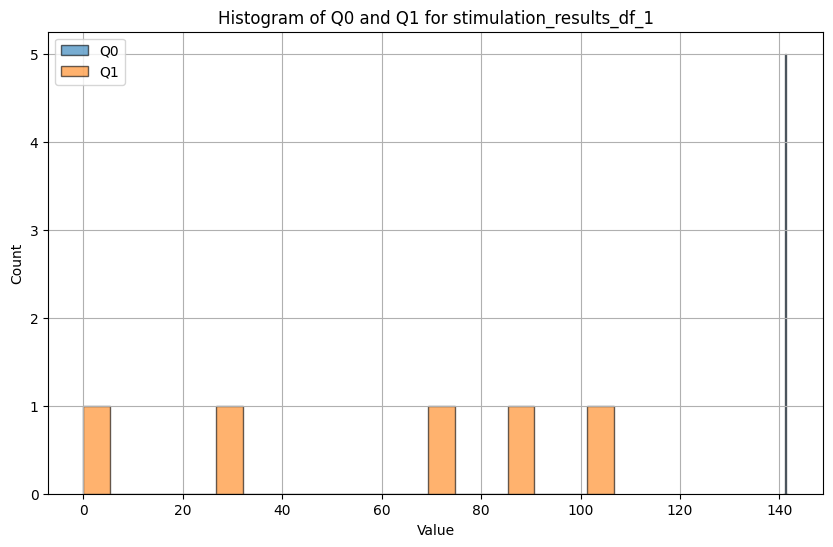

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S2_202411262226.png


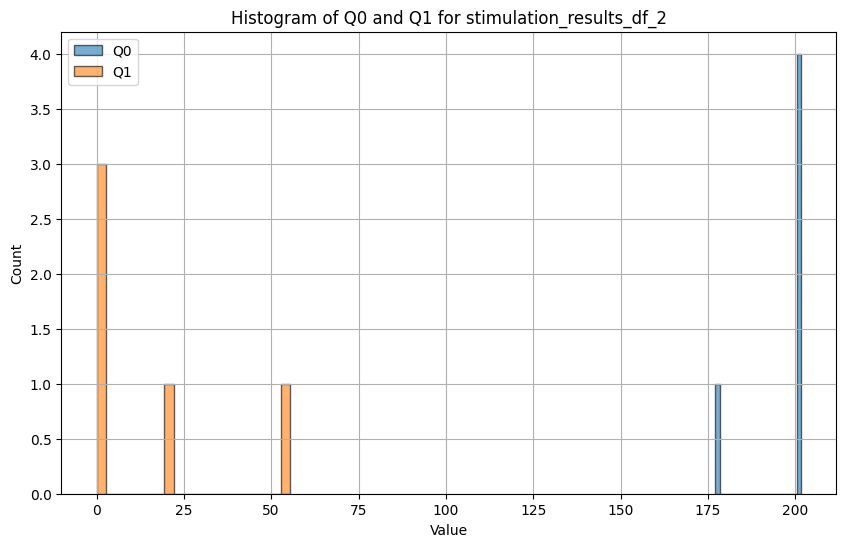

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S3_202411262226.png


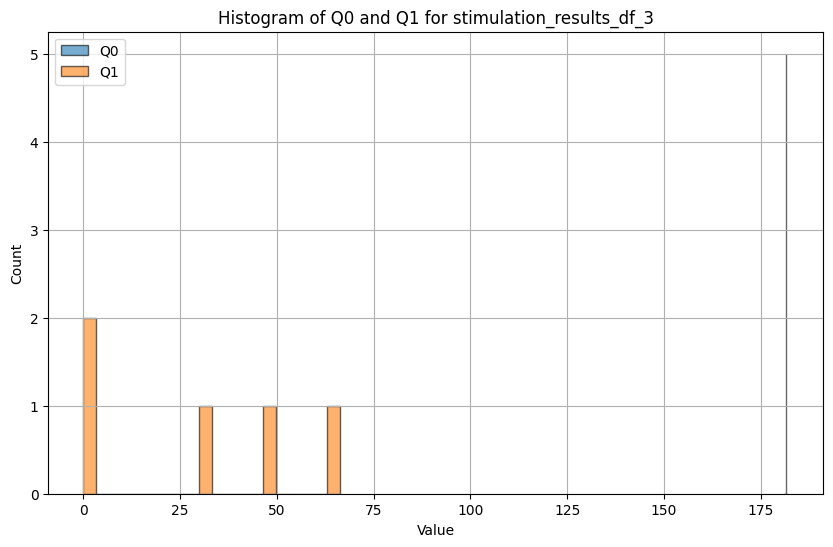

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S4_202411262226.png


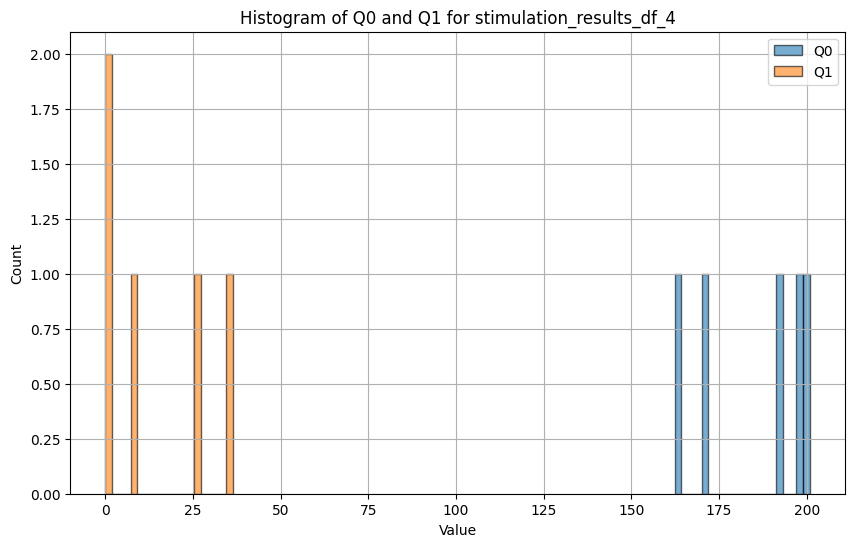

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S6_202411262226.png


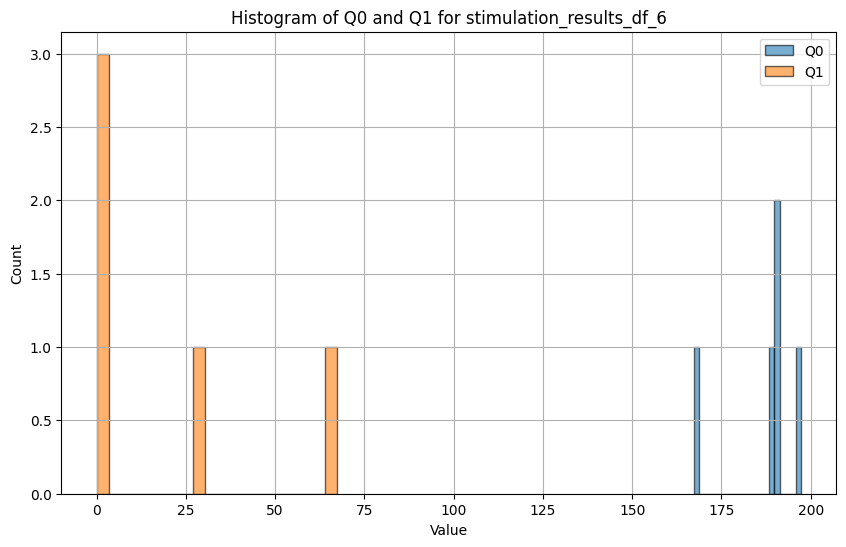

Plot saved as plots/plot_Q0_Q1_distribution_test_linear_constraint_med_with_holding_cost_0_10_S8_202411262226.png


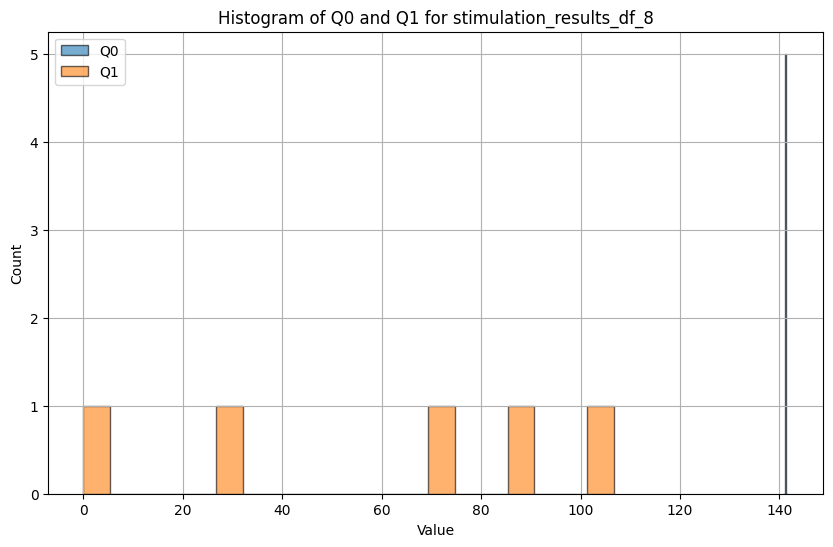

In [381]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S1_202411262226.png


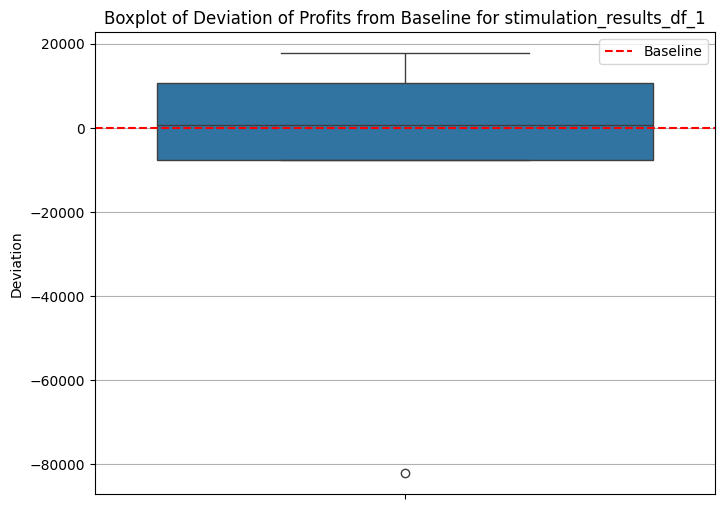

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S2_202411262226.png


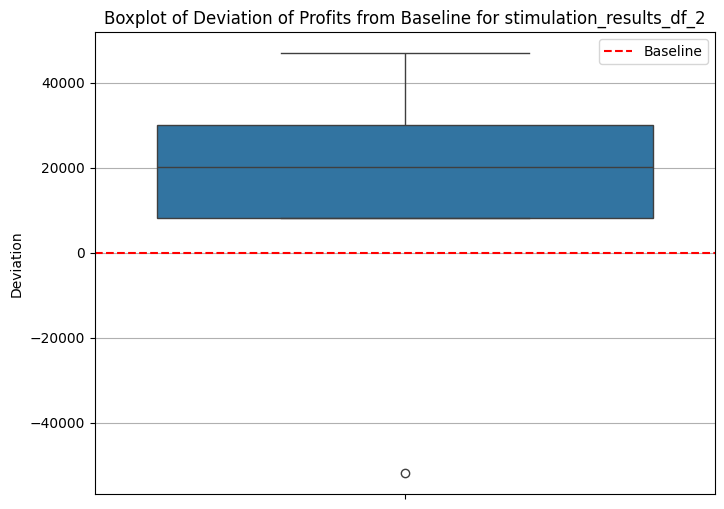

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S3_202411262226.png


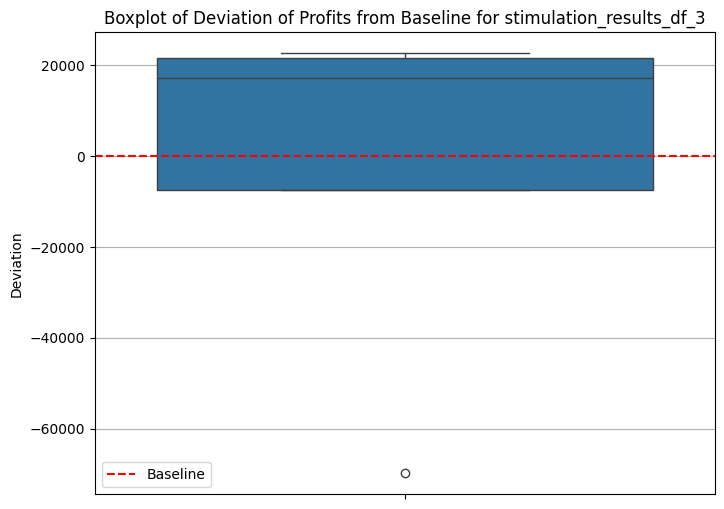

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S4_202411262226.png


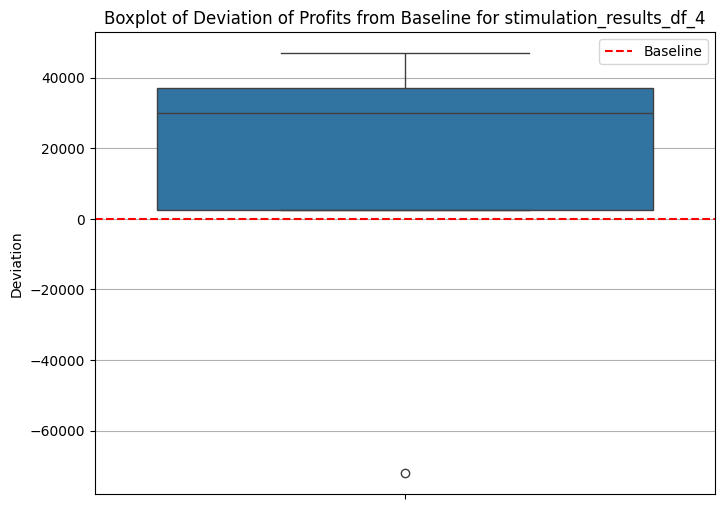

Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S5_202411262226.png


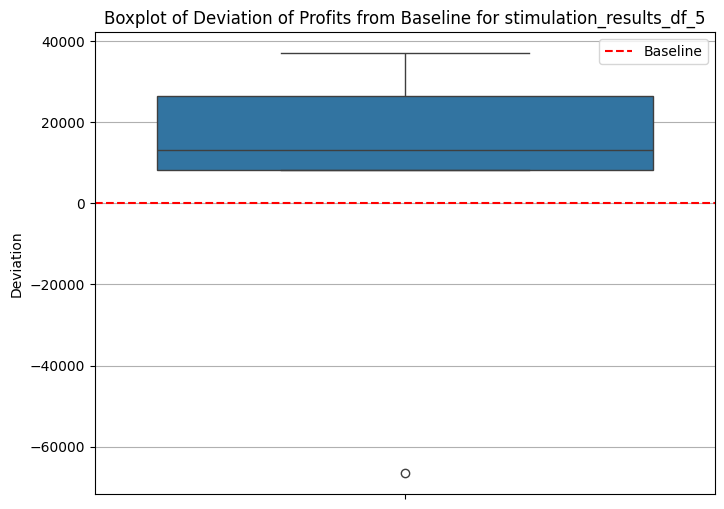

Skipping stimulation_results_df_6: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S7_202411262226.png


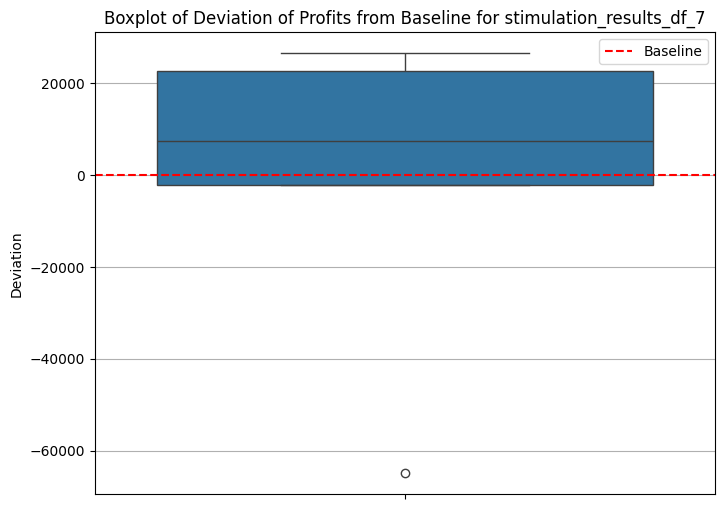

Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_linear_constraint_med_with_holding_cost_0_10_S9_202411262226.png


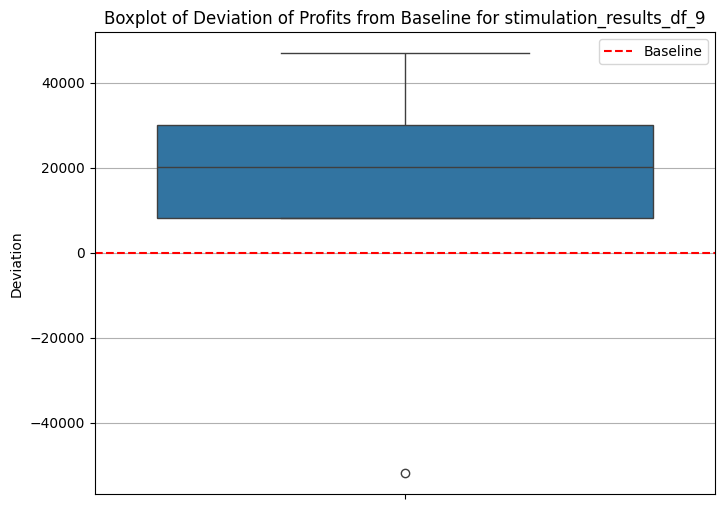

In [382]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_linear_constraint_med_with_holding_cost_0_10_202411262226.png


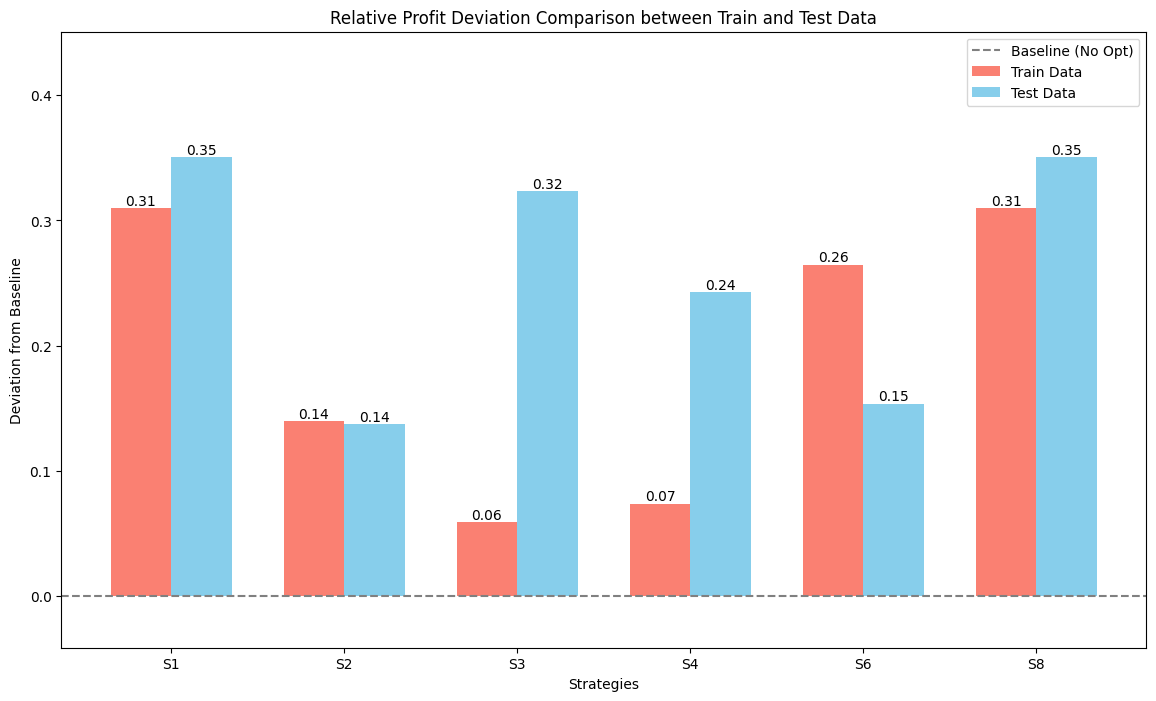

In [383]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

因為 baseline 的 hc 計算是低估的，所以通常其他的策略會比較低是正常的。

因此可以看 S8 的表現來進行相對性的評估會比較正確。

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [384]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [385]:
# # 測試 HC 與 最佳 R, F 的變化

# def visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits):
#     plt.figure(figsize=(15, 10))

#     # Plot R changes
#     plt.subplot(3, 1, 1)
#     plt.plot(holding_cost_list, best_Rs, marker="o", label="Best R")
#     plt.title("HC vs. Best R(T)")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("R(T)")
#     plt.grid(True)
#     plt.legend()

#     # Plot F changes
#     plt.subplot(3, 1, 2)
#     plt.plot(holding_cost_list, best_Fs, marker="o", color="orange", label="Best F")
#     plt.title("HC vs. Best F")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.legend()

#     # Plot profits
#     plt.subplot(3, 1, 3)
#     plt.plot(
#         holding_cost_list,
#         best_profits,
#         marker="o",
#         color="green",
#         label="Average Profits",
#     )
#     plt.title("HC vs. Average Profits")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("Average Profits")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# holding_cost_list = [x for x in range(0, 1050, 50)]
# margins = [
#     {
#         "type": "low",
#         "price": 1000,
#         "cost": 800,
#         "salvage_value": 0,
#     },
#     {
#         "type": "med",
#         "price": 1000,
#         "cost": 500,
#         "salvage_value": 0,
#     },
#     {
#         "type": "high",
#         "price": 1000,
#         "cost": 200,
#         "salvage_value": 0,
#     },
# ]

# for margin in margins:

#     price = margin["price"]
#     cost = margin["cost"]
#     salvage_value = margin["salvage_value"]

#     service_lv = calculate_service_level(
#         salvage_value=salvage_value, cost=cost, price=price
#     )
#     Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)

#     best_Rs = []
#     best_Fs = []
#     best_profits = []

#     for holding_cost in holding_cost_list:

#         results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#             assigned_Ts=ASSIGNED_TS,
#             assigned_Fs=ASSIGNED_FS,
#             cost=cost,
#             price=price,
#             salvage_value=salvage_value,
#             Qk_hat_df=Qk_hat_df_train,
#             demand_df_train=demand_df_train,
#             Q_star=Q_star,
#             holding_cost=holding_cost,
#         )

#         best_Rs.append(results_df_8.iloc[0]["R(T)"])
#         best_Fs.append(results_df_8.iloc[0]["F"])
#         best_profits.append(results_df_8.iloc[0]["average_profits"])

#     print(f"Now at {margin['type']}...\n")
#     visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits)